In [1]:
import os

In [2]:
from model import Actor, Critic, DRRAveStateRepresentation, PMF
from learn import DRRTrainer
from utils.general import csv_plot
import torch
import pickle
import numpy as np
import random
import os
import datetime

import matplotlib.pyplot as plt
 
%matplotlib inline

In [4]:
class config():
    output_path = 'results/' + datetime.datetime.now().strftime('%y%m%d-%H%M%S') + '/'
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    plot_dir = output_path + 'rewards.pdf'
 
    train_actor_loss_data_dir = output_path + 'train_actor_loss_data.npy'
    train_critic_loss_data_dir = output_path + 'train_critic_loss_data.npy'
    train_mean_reward_data_dir = output_path + 'train_mean_reward_data.npy'
 
    train_actor_loss_plot_dir = output_path + 'train_actor_loss.png'
    train_critic_loss_plot_dir = output_path + 'train_critic_loss.png'
    train_mean_reward_plot_dir = output_path + 'train_mean_reward.png'
 
    trained_models_dir = 'dataset/data_runs/'
 
    actor_model_trained = trained_models_dir + 'actor_net.weights'
    critic_model_trained = trained_models_dir + 'critic_net.weights'
    state_rep_model_trained = trained_models_dir + 'state_rep_net.weights'
 
    actor_model_dir = output_path + 'actor_net.weights'
    critic_model_dir = output_path + 'critic_net.weights'
    state_rep_model_dir = output_path + 'state_rep_net.weights'
 
    csv_dir = output_path + 'log.csv'
 
    path_to_trained_pmf = trained_models_dir + 'ratio_0.800000_bs_100000_e_71_wd_0.100000_lr_0.000100_trained_pmf.pt'
 
    # hyperparams
    batch_size = 64
    gamma = 0.9
    replay_buffer_size = 100000
    history_buffer_size = 5
    learning_start = 5000
    learning_freq = 1
    lr_state_rep = 0.001
    lr_actor = 0.0001
    lr_critic = 0.001
    eps_start = 1
    eps = 0.1
    eps_steps = 10000
    eps_eval = 0.1
    tau = 0.01 # inital 0.001
    beta = 0.4
    prob_alpha = 0.3
    max_timesteps_train = 260000
    max_epochs_offline = 500
    max_timesteps_online = 20000
    embedding_feature_size = 100
    episode_length = 10
    train_ratio = 0.8
    weight_decay = 0.01
    clip_val = 1.0
    log_freq = 100
    saving_freq = 1000
    zero_reward = False
 
    no_cuda = True #False

In [5]:
def seed_all(cuda, seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.empty_cache()
        torch.cuda.manual_seed(seed=seed)

In [6]:
print("Initializing DRR Framework ----------------------------------------------------------------------------")
 
# Get CUDA device if available
cuda = True if not config.no_cuda and torch.cuda.is_available() else False
print("Using CUDA") if cuda else print("Using CPU")


 
# Init seeds
# seed_all(mps, 0)
seed_all(cuda, 0)
print("Seeds initialized")
 
# Grab models
actor_function = Actor
critic_function = Critic
state_rep_function = DRRAveStateRepresentation
 
# Import Data
users = pickle.load(open('dataset/user_id_to_num.pkl', 'rb'))
items = pickle.load(open('dataset/rest_id_to_num.pkl', 'rb'))
data = np.load('dataset/data_new.npy', allow_pickle=True)

Initializing DRR Framework ----------------------------------------------------------------------------
Using CPU
Seeds initialized


In [7]:
# Normalize rewards to [-1, 1]
data[:, 0] = 0.5 * (data[:, 0] - 3)

data = data[:,:-1] # PMF only need id and stars
data = data.astype(np.float64)
data

array([[ 0.00000e+00,  5.40278e+05,  3.30000e+01,  4.06000e+00,
         8.07390e+04,  3.00000e+00],
       [-5.00000e-01,  6.61290e+04,  3.90000e+01,  3.05000e+00,
         8.07390e+04,  3.00000e+00],
       [ 0.00000e+00,  6.47623e+05,  4.90000e+02,  3.33000e+00,
         8.07390e+04,  3.00000e+00],
       ...,
       [ 1.00000e+00,  2.09320e+05,  1.90000e+01,  4.37000e+00,
         1.44618e+05,  3.00000e+00],
       [ 1.00000e+00,  3.68960e+05,  1.50000e+01,  4.27000e+00,
         9.18410e+04,  5.00000e+00],
       [ 1.00000e+00,  2.01480e+04,  1.30000e+01,  5.00000e+00,
         1.07300e+05,  4.00000e+00]])

In [8]:
# Shuffle data
np.random.shuffle(data)

# Split data
train_data = torch.from_numpy(data[:int(config.train_ratio * data.shape[0])])
test_data = torch.from_numpy(data[int(config.train_ratio * data.shape[0]):])

print("Data imported, shuffled, and split into Train/Test, ratio=", config.train_ratio)
print("Train data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)

Data imported, shuffled, and split into Train/Test, ratio= 0.8
Train data shape:  torch.Size([3778726, 6])
Test data shape:  torch.Size([944682, 6])


In [9]:
# Create and load PMF function for rewards and embeddings
n_users = len(users)
n_items = len(items)

reward_function = PMF(n_users, n_items, config.embedding_feature_size, is_sparse=False, no_cuda=~cuda) #~mps
reward_function.load_state_dict(torch.load(config.path_to_trained_pmf))
 
# Freeze all the parameters in the network
for param in reward_function.parameters():
    param.requires_grad = False
print("Initialized PMF, imported weights, created reward_function")
 
# Extract embeddings
user_embeddings = reward_function.user_embeddings.weight.data
item_embeddings = reward_function.item_embeddings.weight.data
print("Extracted user and item embeddings from PMF")
print("User embeddings shape: ", user_embeddings.shape)
print("Item embeddings shape: ", item_embeddings.shape)

Initialized PMF, imported weights, created reward_function
Extracted user and item embeddings from PMF
User embeddings shape:  torch.Size([681956, 100])
Item embeddings shape:  torch.Size([150346, 100])


In [10]:
reward_function

PMF(
  (user_embeddings): Embedding(681956, 100)
  (item_embeddings): Embedding(150346, 100)
  (ub): Embedding(681956, 1)
  (ib): Embedding(150346, 1)
)

In [11]:
cuda

False

In [12]:
# Init trainer
print("Initializing DRRTrainer -------------------------------------------------------------------------------")
trainer = DRRTrainer(config,
                      actor_function,
                      critic_function,
                      state_rep_function,
                      reward_function,
                      users,
                      items,
                      train_data,
                      test_data,
                      user_embeddings,
                      item_embeddings,
                      cuda #mps #cuda
                      )

Initializing DRRTrainer -------------------------------------------------------------------------------
Current PyTorch Device:  cpu
Data dimensions extracted
Models initialized
Model weights initialized, copied to target
Optimizers initialized


In [13]:
# Train
print("Starting DRRTrainer.learn() ---------------------------------------------------------------------------")
actor_losses, critic_losses, epi_avg_rewards = trainer.learn()

Starting DRRTrainer.learn() ---------------------------------------------------------------------------


/Users/yihuashen/Downloads/slate_restaurant-main/Final Project/learn.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 9 | Mean Ep R 0.0493 | Max R 0.0493 | Critic Params Norm 0.2885 | Actor Loss -0.8470 | Critic Loss 0.0493 | 
Timestep 200 | Episode 19 | Mean Ep R 0.6156 | Max R 0.6156 | Critic Params Norm 0.1163 | Actor Loss -1.6368 | Critic Loss 0.0440 | 
Timestep 300 | Episode 29 | Mean Ep R 1.1263 | Max R 1.1263 | Critic Params Norm 0.9065 | Actor Loss -2.8562 | Critic Loss 0.0727 | 
Timestep 400 | Episode 39 | Mean Ep R 0.9025 | Max R 0.9025 | Critic Params Norm 0.9054 | Actor Loss -3.0507 | Critic Loss 0.0510 | 
Timestep 500 | Episode 49 | Mean Ep R 0.6361 | Max R 0.6361 | Critic Params Norm 0.7567 | Actor Loss -3.0504 | Critic Loss 0.0510 | 
Timestep 600 | Episode 59 | Mean Ep R 1.0000 | Max R 1.0000 | Critic Params Norm 2.3207 | Actor Loss -4.6081 | Critic Loss 0.0692 | 
Timestep 700 | Episode 69 | Mean Ep R 0.1929 | Max R 0.1929 | Critic Params Norm 0.4414 | Actor Loss -5.1609 | Critic Loss 0.0381 | 
Timestep 800 | Episode 79 | Mean Ep R 1.0090 | Max R 1.0090 | Critic P

Timestep 6200 | Episode 619 | Mean Ep R 0.8223 | Max R 0.8223 | Critic Params Norm 12.8474 | Actor Loss -10.6818 | Critic Loss 0.0946 | 
Timestep 6300 | Episode 629 | Mean Ep R 0.5413 | Max R 0.5413 | Critic Params Norm 8.5465 | Actor Loss -9.8305 | Critic Loss 0.1293 | 
Timestep 6400 | Episode 639 | Mean Ep R 0.6087 | Max R 0.6087 | Critic Params Norm 13.5656 | Actor Loss -10.5029 | Critic Loss 0.1002 | 
Timestep 6500 | Episode 649 | Mean Ep R 0.6803 | Max R 0.6803 | Critic Params Norm 6.1369 | Actor Loss -9.8312 | Critic Loss 0.1011 | 
Timestep 6600 | Episode 659 | Mean Ep R 0.8727 | Max R 0.8727 | Critic Params Norm 14.6929 | Actor Loss -10.2787 | Critic Loss 0.1207 | 
Timestep 6700 | Episode 669 | Mean Ep R 0.5645 | Max R 0.5645 | Critic Params Norm 3.3018 | Actor Loss -11.4805 | Critic Loss 0.1052 | 
Timestep 6800 | Episode 679 | Mean Ep R 0.3382 | Max R 0.3382 | Critic Params Norm 19.1014 | Actor Loss -10.8553 | Critic Loss 0.1694 | 
Timestep 6900 | Episode 689 | Mean Ep R 0.9117

Timestep 12200 | Episode 1219 | Mean Ep R 0.7490 | Max R 0.7490 | Critic Params Norm 4.6642 | Actor Loss -9.7125 | Critic Loss 0.1210 | 
Timestep 12300 | Episode 1229 | Mean Ep R 0.8970 | Max R 0.8970 | Critic Params Norm 8.4184 | Actor Loss -10.0145 | Critic Loss 0.1222 | 
Timestep 12400 | Episode 1239 | Mean Ep R 0.8020 | Max R 0.8020 | Critic Params Norm 30.3654 | Actor Loss -9.3643 | Critic Loss 0.2340 | 
Timestep 12500 | Episode 1249 | Mean Ep R 0.1514 | Max R 0.1514 | Critic Params Norm 28.1219 | Actor Loss -9.8233 | Critic Loss 0.1745 | 
Timestep 12600 | Episode 1259 | Mean Ep R 0.8362 | Max R 0.8362 | Critic Params Norm 9.9660 | Actor Loss -8.9643 | Critic Loss 0.1000 | 
Timestep 12700 | Episode 1269 | Mean Ep R 1.0760 | Max R 1.0760 | Critic Params Norm 20.6708 | Actor Loss -9.1656 | Critic Loss 0.1774 | 
Timestep 12800 | Episode 1279 | Mean Ep R 0.9529 | Max R 0.9529 | Critic Params Norm 5.3776 | Actor Loss -9.6462 | Critic Loss 0.0977 | 
Timestep 12900 | Episode 1289 | Mean 

Timestep 18200 | Episode 1819 | Mean Ep R 0.3229 | Max R 0.3229 | Critic Params Norm 31.8458 | Actor Loss -9.2980 | Critic Loss 0.2053 | 
Timestep 18300 | Episode 1829 | Mean Ep R 1.2245 | Max R 1.2245 | Critic Params Norm 16.8266 | Actor Loss -8.3977 | Critic Loss 0.0969 | 
Timestep 18400 | Episode 1839 | Mean Ep R 0.4006 | Max R 0.4006 | Critic Params Norm 12.2108 | Actor Loss -9.1068 | Critic Loss 0.1133 | 
Timestep 18500 | Episode 1849 | Mean Ep R 1.3005 | Max R 1.3005 | Critic Params Norm 25.7758 | Actor Loss -9.2834 | Critic Loss 0.2124 | 
Timestep 18600 | Episode 1859 | Mean Ep R 0.8120 | Max R 0.8120 | Critic Params Norm 13.3048 | Actor Loss -9.5311 | Critic Loss 0.1629 | 
Timestep 18700 | Episode 1869 | Mean Ep R 0.3582 | Max R 0.3582 | Critic Params Norm 18.3112 | Actor Loss -9.3088 | Critic Loss 0.1498 | 
Timestep 18800 | Episode 1879 | Mean Ep R 0.2844 | Max R 0.2844 | Critic Params Norm 4.3913 | Actor Loss -8.7497 | Critic Loss 0.1252 | 
Timestep 18900 | Episode 1889 | Mea

Timestep 24200 | Episode 2419 | Mean Ep R -0.0967 | Max R -0.0967 | Critic Params Norm 20.6097 | Actor Loss -8.9340 | Critic Loss 0.1241 | 
Timestep 24300 | Episode 2429 | Mean Ep R 0.3723 | Max R 0.3723 | Critic Params Norm 8.4433 | Actor Loss -9.2434 | Critic Loss 0.1291 | 
Timestep 24400 | Episode 2439 | Mean Ep R 0.5325 | Max R 0.5325 | Critic Params Norm 6.8857 | Actor Loss -9.1449 | Critic Loss 0.0788 | 
Timestep 24500 | Episode 2449 | Mean Ep R 0.6092 | Max R 0.6092 | Critic Params Norm 21.9088 | Actor Loss -8.6819 | Critic Loss 0.1675 | 
Timestep 24600 | Episode 2459 | Mean Ep R 0.9920 | Max R 0.9920 | Critic Params Norm 39.1829 | Actor Loss -8.7814 | Critic Loss 0.2239 | 
Timestep 24700 | Episode 2469 | Mean Ep R 0.9742 | Max R 0.9742 | Critic Params Norm 29.3110 | Actor Loss -8.6405 | Critic Loss 0.1695 | 
Timestep 24800 | Episode 2479 | Mean Ep R 0.4513 | Max R 0.4513 | Critic Params Norm 5.2694 | Actor Loss -8.7492 | Critic Loss 0.0809 | 
Timestep 24900 | Episode 2489 | Mea

Timestep 30200 | Episode 3019 | Mean Ep R 0.4442 | Max R 0.4442 | Critic Params Norm 15.3449 | Actor Loss -8.5372 | Critic Loss 0.0809 | 
Timestep 30300 | Episode 3029 | Mean Ep R 0.8702 | Max R 0.8702 | Critic Params Norm 16.9173 | Actor Loss -8.4690 | Critic Loss 0.1414 | 
Timestep 30400 | Episode 3039 | Mean Ep R 0.7292 | Max R 0.7292 | Critic Params Norm 13.8266 | Actor Loss -8.6655 | Critic Loss 0.1178 | 
Timestep 30500 | Episode 3049 | Mean Ep R 1.0216 | Max R 1.0216 | Critic Params Norm 17.4925 | Actor Loss -7.9847 | Critic Loss 0.1207 | 
Timestep 30600 | Episode 3059 | Mean Ep R 0.3817 | Max R 0.3817 | Critic Params Norm 10.1566 | Actor Loss -8.6922 | Critic Loss 0.1151 | 
Timestep 30700 | Episode 3069 | Mean Ep R 0.8803 | Max R 0.8803 | Critic Params Norm 3.8975 | Actor Loss -8.5253 | Critic Loss 0.0962 | 
Timestep 30800 | Episode 3079 | Mean Ep R 0.9488 | Max R 0.9488 | Critic Params Norm 7.1206 | Actor Loss -8.3620 | Critic Loss 0.0964 | 
Timestep 30900 | Episode 3089 | Mean

Timestep 36200 | Episode 3619 | Mean Ep R 0.6365 | Max R 0.6365 | Critic Params Norm 19.5184 | Actor Loss -8.9314 | Critic Loss 0.1345 | 
Timestep 36300 | Episode 3629 | Mean Ep R 1.2577 | Max R 1.2577 | Critic Params Norm 20.9068 | Actor Loss -8.9445 | Critic Loss 0.1312 | 
Timestep 36400 | Episode 3639 | Mean Ep R 0.8678 | Max R 0.8678 | Critic Params Norm 24.2164 | Actor Loss -8.2432 | Critic Loss 0.1396 | 
Timestep 36500 | Episode 3649 | Mean Ep R 0.2013 | Max R 0.2013 | Critic Params Norm 17.8291 | Actor Loss -8.8366 | Critic Loss 0.1135 | 
Timestep 36600 | Episode 3659 | Mean Ep R 0.6199 | Max R 0.6199 | Critic Params Norm 6.5711 | Actor Loss -9.4510 | Critic Loss 0.0995 | 
Timestep 36700 | Episode 3669 | Mean Ep R 0.8524 | Max R 0.8524 | Critic Params Norm 5.9817 | Actor Loss -8.6155 | Critic Loss 0.1319 | 
Timestep 36800 | Episode 3679 | Mean Ep R 1.3048 | Max R 1.3048 | Critic Params Norm 13.0779 | Actor Loss -9.1014 | Critic Loss 0.1538 | 
Timestep 36900 | Episode 3689 | Mean

Timestep 42200 | Episode 4219 | Mean Ep R 1.2113 | Max R 1.2113 | Critic Params Norm 44.4257 | Actor Loss -8.6958 | Critic Loss 0.2359 | 
Timestep 42300 | Episode 4229 | Mean Ep R 1.1905 | Max R 1.1905 | Critic Params Norm 30.3710 | Actor Loss -9.2550 | Critic Loss 0.1775 | 
Timestep 42400 | Episode 4239 | Mean Ep R 0.4994 | Max R 0.4994 | Critic Params Norm 2.7655 | Actor Loss -9.0358 | Critic Loss 0.0955 | 
Timestep 42500 | Episode 4249 | Mean Ep R 1.1646 | Max R 1.1646 | Critic Params Norm 30.0931 | Actor Loss -8.5317 | Critic Loss 0.1522 | 
Timestep 42600 | Episode 4259 | Mean Ep R 0.5000 | Max R 0.5000 | Critic Params Norm 5.3793 | Actor Loss -9.2807 | Critic Loss 0.1073 | 
Timestep 42700 | Episode 4269 | Mean Ep R -1.0519 | Max R -1.0519 | Critic Params Norm 16.3996 | Actor Loss -8.7545 | Critic Loss 0.1985 | 
Timestep 42800 | Episode 4279 | Mean Ep R 0.4302 | Max R 0.4302 | Critic Params Norm 63.7496 | Actor Loss -8.9602 | Critic Loss 0.3147 | 
Timestep 42900 | Episode 4289 | Me

Timestep 48200 | Episode 4819 | Mean Ep R -0.1861 | Max R -0.1861 | Critic Params Norm 29.0038 | Actor Loss -7.8808 | Critic Loss 0.1469 | 
Timestep 48300 | Episode 4829 | Mean Ep R 0.6624 | Max R 0.6624 | Critic Params Norm 13.7926 | Actor Loss -8.5344 | Critic Loss 0.1087 | 
Timestep 48400 | Episode 4839 | Mean Ep R 0.9287 | Max R 0.9287 | Critic Params Norm 27.2132 | Actor Loss -8.3928 | Critic Loss 0.1297 | 
Timestep 48500 | Episode 4849 | Mean Ep R 0.8897 | Max R 0.8897 | Critic Params Norm 12.3183 | Actor Loss -8.3636 | Critic Loss 0.1337 | 
Timestep 48600 | Episode 4859 | Mean Ep R -0.2908 | Max R -0.2908 | Critic Params Norm 11.2511 | Actor Loss -8.0664 | Critic Loss 0.0743 | 
Timestep 48700 | Episode 4869 | Mean Ep R 0.8083 | Max R 0.8083 | Critic Params Norm 7.0889 | Actor Loss -8.3341 | Critic Loss 0.1568 | 
Timestep 48800 | Episode 4879 | Mean Ep R 0.7883 | Max R 0.7883 | Critic Params Norm 46.4561 | Actor Loss -8.1333 | Critic Loss 0.2504 | 
Timestep 48900 | Episode 4889 |

Timestep 54200 | Episode 5419 | Mean Ep R 0.8323 | Max R 0.8323 | Critic Params Norm 7.9908 | Actor Loss -8.7277 | Critic Loss 0.1139 | 
Timestep 54300 | Episode 5429 | Mean Ep R 0.7893 | Max R 0.7893 | Critic Params Norm 9.7144 | Actor Loss -8.2273 | Critic Loss 0.1270 | 
Timestep 54400 | Episode 5439 | Mean Ep R 0.8312 | Max R 0.8312 | Critic Params Norm 11.9394 | Actor Loss -8.7855 | Critic Loss 0.1392 | 
Timestep 54500 | Episode 5449 | Mean Ep R 0.3394 | Max R 0.3394 | Critic Params Norm 30.0078 | Actor Loss -9.4597 | Critic Loss 0.1585 | 
Timestep 54600 | Episode 5459 | Mean Ep R 0.7328 | Max R 0.7328 | Critic Params Norm 7.5538 | Actor Loss -8.6878 | Critic Loss 0.0935 | 
Timestep 54700 | Episode 5469 | Mean Ep R 1.0824 | Max R 1.0824 | Critic Params Norm 12.4444 | Actor Loss -8.4558 | Critic Loss 0.0859 | 
Timestep 54800 | Episode 5479 | Mean Ep R 1.1459 | Max R 1.1459 | Critic Params Norm 21.1632 | Actor Loss -8.7253 | Critic Loss 0.1245 | 
Timestep 54900 | Episode 5489 | Mean 

Timestep 60200 | Episode 6019 | Mean Ep R 0.6562 | Max R 0.6562 | Critic Params Norm 13.3856 | Actor Loss -8.6289 | Critic Loss 0.1659 | 
Timestep 60300 | Episode 6029 | Mean Ep R 0.9949 | Max R 0.9949 | Critic Params Norm 33.7347 | Actor Loss -8.1706 | Critic Loss 0.1460 | 
Timestep 60400 | Episode 6039 | Mean Ep R 0.6775 | Max R 0.6775 | Critic Params Norm 9.6726 | Actor Loss -8.7103 | Critic Loss 0.0925 | 
Timestep 60500 | Episode 6049 | Mean Ep R 1.0767 | Max R 1.0767 | Critic Params Norm 28.2673 | Actor Loss -9.0742 | Critic Loss 0.1408 | 
Timestep 60600 | Episode 6059 | Mean Ep R 0.6357 | Max R 0.6357 | Critic Params Norm 3.1089 | Actor Loss -8.9436 | Critic Loss 0.0735 | 
Timestep 60700 | Episode 6069 | Mean Ep R 0.3914 | Max R 0.3914 | Critic Params Norm 5.4415 | Actor Loss -9.9636 | Critic Loss 0.0883 | 
Timestep 60800 | Episode 6079 | Mean Ep R 0.8330 | Max R 0.8330 | Critic Params Norm 18.6709 | Actor Loss -9.0958 | Critic Loss 0.1337 | 
Timestep 60900 | Episode 6089 | Mean 

Timestep 66200 | Episode 6619 | Mean Ep R 0.3755 | Max R 0.3755 | Critic Params Norm 11.3768 | Actor Loss -8.8746 | Critic Loss 0.0959 | 
Timestep 66300 | Episode 6629 | Mean Ep R -0.3931 | Max R -0.3931 | Critic Params Norm 17.7217 | Actor Loss -9.2866 | Critic Loss 0.1232 | 
Timestep 66400 | Episode 6639 | Mean Ep R 0.3604 | Max R 0.3604 | Critic Params Norm 19.4859 | Actor Loss -9.0778 | Critic Loss 0.1292 | 
Timestep 66500 | Episode 6649 | Mean Ep R 0.8817 | Max R 0.8817 | Critic Params Norm 5.6739 | Actor Loss -8.4211 | Critic Loss 0.1168 | 
Timestep 66600 | Episode 6659 | Mean Ep R 0.9640 | Max R 0.9640 | Critic Params Norm 3.1360 | Actor Loss -8.2042 | Critic Loss 0.0783 | 
Timestep 66700 | Episode 6669 | Mean Ep R 0.5287 | Max R 0.5287 | Critic Params Norm 5.1180 | Actor Loss -9.5742 | Critic Loss 0.1024 | 
Timestep 66800 | Episode 6679 | Mean Ep R 0.5324 | Max R 0.5324 | Critic Params Norm 42.1239 | Actor Loss -9.1710 | Critic Loss 0.2097 | 
Timestep 66900 | Episode 6689 | Mea

Timestep 72200 | Episode 7219 | Mean Ep R 0.3865 | Max R 0.3865 | Critic Params Norm 17.4731 | Actor Loss -8.2722 | Critic Loss 0.2009 | 
Timestep 72300 | Episode 7229 | Mean Ep R 0.6642 | Max R 0.6642 | Critic Params Norm 17.2068 | Actor Loss -8.3692 | Critic Loss 0.1328 | 
Timestep 72400 | Episode 7239 | Mean Ep R 0.6976 | Max R 0.6976 | Critic Params Norm 9.1538 | Actor Loss -8.7450 | Critic Loss 0.1824 | 
Timestep 72500 | Episode 7249 | Mean Ep R 0.6924 | Max R 0.6924 | Critic Params Norm 22.1644 | Actor Loss -8.7710 | Critic Loss 0.0990 | 
Timestep 72600 | Episode 7259 | Mean Ep R 1.3431 | Max R 1.3431 | Critic Params Norm 6.8947 | Actor Loss -8.8987 | Critic Loss 0.1366 | 
Timestep 72700 | Episode 7269 | Mean Ep R 0.7817 | Max R 0.7817 | Critic Params Norm 8.8075 | Actor Loss -8.5221 | Critic Loss 0.1034 | 
Timestep 72800 | Episode 7279 | Mean Ep R 0.9062 | Max R 0.9062 | Critic Params Norm 4.1135 | Actor Loss -8.4791 | Critic Loss 0.1262 | 
Timestep 72900 | Episode 7289 | Mean E

Timestep 78200 | Episode 7819 | Mean Ep R 0.9653 | Max R 0.9653 | Critic Params Norm 10.4639 | Actor Loss -8.7983 | Critic Loss 0.1332 | 
Timestep 78300 | Episode 7829 | Mean Ep R 0.7972 | Max R 0.7972 | Critic Params Norm 34.7270 | Actor Loss -8.4728 | Critic Loss 0.1824 | 
Timestep 78400 | Episode 7839 | Mean Ep R 0.5311 | Max R 0.5311 | Critic Params Norm 4.5974 | Actor Loss -9.0567 | Critic Loss 0.1249 | 
Timestep 78500 | Episode 7849 | Mean Ep R 0.9363 | Max R 0.9363 | Critic Params Norm 8.8112 | Actor Loss -8.7540 | Critic Loss 0.0856 | 
Timestep 78600 | Episode 7859 | Mean Ep R 0.5148 | Max R 0.5148 | Critic Params Norm 14.9444 | Actor Loss -9.2235 | Critic Loss 0.1183 | 
Timestep 78700 | Episode 7869 | Mean Ep R 0.8126 | Max R 0.8126 | Critic Params Norm 16.1588 | Actor Loss -9.3466 | Critic Loss 0.0857 | 
Timestep 78800 | Episode 7879 | Mean Ep R 0.1658 | Max R 0.1658 | Critic Params Norm 7.2308 | Actor Loss -9.2193 | Critic Loss 0.1417 | 
Timestep 78900 | Episode 7889 | Mean 

Timestep 84200 | Episode 8419 | Mean Ep R 0.9723 | Max R 0.9723 | Critic Params Norm 23.3797 | Actor Loss -8.2933 | Critic Loss 0.1387 | 
Timestep 84300 | Episode 8429 | Mean Ep R 0.8615 | Max R 0.8615 | Critic Params Norm 53.3872 | Actor Loss -9.2060 | Critic Loss 0.2208 | 
Timestep 84400 | Episode 8439 | Mean Ep R 0.5202 | Max R 0.5202 | Critic Params Norm 17.0432 | Actor Loss -8.1632 | Critic Loss 0.1490 | 
Timestep 84500 | Episode 8449 | Mean Ep R 0.5496 | Max R 0.5496 | Critic Params Norm 13.1714 | Actor Loss -8.7685 | Critic Loss 0.1289 | 
Timestep 84600 | Episode 8459 | Mean Ep R 0.2976 | Max R 0.2976 | Critic Params Norm 7.6679 | Actor Loss -8.2053 | Critic Loss 0.0808 | 
Timestep 84700 | Episode 8469 | Mean Ep R 0.9099 | Max R 0.9099 | Critic Params Norm 35.5974 | Actor Loss -8.8055 | Critic Loss 0.1591 | 
Timestep 84800 | Episode 8479 | Mean Ep R 0.0076 | Max R 0.0076 | Critic Params Norm 12.1587 | Actor Loss -8.3511 | Critic Loss 0.0676 | 
Timestep 84900 | Episode 8489 | Mea

Timestep 90200 | Episode 9019 | Mean Ep R 0.6083 | Max R 0.6083 | Critic Params Norm 6.6562 | Actor Loss -8.1877 | Critic Loss 0.1126 | 
Timestep 90300 | Episode 9029 | Mean Ep R 0.8085 | Max R 0.8085 | Critic Params Norm 3.5242 | Actor Loss -8.8006 | Critic Loss 0.1156 | 
Timestep 90400 | Episode 9039 | Mean Ep R 0.4218 | Max R 0.4218 | Critic Params Norm 7.3728 | Actor Loss -8.4233 | Critic Loss 0.0967 | 
Timestep 90500 | Episode 9049 | Mean Ep R 0.6645 | Max R 0.6645 | Critic Params Norm 12.5816 | Actor Loss -8.8257 | Critic Loss 0.1118 | 
Timestep 90600 | Episode 9059 | Mean Ep R 0.6091 | Max R 0.6091 | Critic Params Norm 5.8590 | Actor Loss -8.6028 | Critic Loss 0.1336 | 
Timestep 90700 | Episode 9069 | Mean Ep R 0.7321 | Max R 0.7321 | Critic Params Norm 19.8171 | Actor Loss -7.9278 | Critic Loss 0.1178 | 
Timestep 90800 | Episode 9079 | Mean Ep R 1.3054 | Max R 1.3054 | Critic Params Norm 33.1830 | Actor Loss -8.2102 | Critic Loss 0.1233 | 
Timestep 90900 | Episode 9089 | Mean E

Timestep 96200 | Episode 9619 | Mean Ep R 0.8196 | Max R 0.8196 | Critic Params Norm 8.8725 | Actor Loss -8.4293 | Critic Loss 0.0855 | 
Timestep 96300 | Episode 9629 | Mean Ep R 0.7877 | Max R 0.7877 | Critic Params Norm 23.3104 | Actor Loss -8.4972 | Critic Loss 0.1103 | 
Timestep 96400 | Episode 9639 | Mean Ep R 0.5125 | Max R 0.5125 | Critic Params Norm 7.3708 | Actor Loss -8.3332 | Critic Loss 0.1201 | 
Timestep 96500 | Episode 9649 | Mean Ep R 0.9210 | Max R 0.9210 | Critic Params Norm 6.1204 | Actor Loss -8.4699 | Critic Loss 0.1026 | 
Timestep 96600 | Episode 9659 | Mean Ep R 1.2539 | Max R 1.2539 | Critic Params Norm 6.4509 | Actor Loss -8.2767 | Critic Loss 0.1069 | 
Timestep 96700 | Episode 9669 | Mean Ep R 0.3884 | Max R 0.3884 | Critic Params Norm 29.3921 | Actor Loss -8.7291 | Critic Loss 0.1398 | 
Timestep 96800 | Episode 9679 | Mean Ep R 0.5554 | Max R 0.5554 | Critic Params Norm 7.5500 | Actor Loss -8.4459 | Critic Loss 0.0852 | 
Timestep 96900 | Episode 9689 | Mean Ep

Timestep 102200 | Episode 10219 | Mean Ep R 0.4597 | Max R 0.4597 | Critic Params Norm 25.6911 | Actor Loss -8.0021 | Critic Loss 0.1467 | 
Timestep 102300 | Episode 10229 | Mean Ep R 0.8483 | Max R 0.8483 | Critic Params Norm 15.1061 | Actor Loss -8.2002 | Critic Loss 0.1161 | 
Timestep 102400 | Episode 10239 | Mean Ep R 0.0134 | Max R 0.0134 | Critic Params Norm 17.0475 | Actor Loss -8.5028 | Critic Loss 0.0988 | 
Timestep 102500 | Episode 10249 | Mean Ep R 1.2579 | Max R 1.2579 | Critic Params Norm 26.8816 | Actor Loss -7.8761 | Critic Loss 0.1282 | 
Timestep 102600 | Episode 10259 | Mean Ep R 1.0428 | Max R 1.0428 | Critic Params Norm 3.2875 | Actor Loss -8.0258 | Critic Loss 0.1038 | 
Timestep 102700 | Episode 10269 | Mean Ep R 0.8437 | Max R 0.8437 | Critic Params Norm 38.5790 | Actor Loss -8.6555 | Critic Loss 0.1473 | 
Timestep 102800 | Episode 10279 | Mean Ep R 0.5131 | Max R 0.5131 | Critic Params Norm 22.6062 | Actor Loss -8.2264 | Critic Loss 0.1190 | 
Timestep 102900 | Epi

Timestep 108100 | Episode 10809 | Mean Ep R -0.0979 | Max R -0.0979 | Critic Params Norm 36.8587 | Actor Loss -8.0277 | Critic Loss 0.1715 | 
Timestep 108200 | Episode 10819 | Mean Ep R 0.7315 | Max R 0.7315 | Critic Params Norm 2.8969 | Actor Loss -9.0147 | Critic Loss 0.0625 | 
Timestep 108300 | Episode 10829 | Mean Ep R 0.2921 | Max R 0.2921 | Critic Params Norm 20.2163 | Actor Loss -9.0952 | Critic Loss 0.1262 | 
Timestep 108400 | Episode 10839 | Mean Ep R 0.4252 | Max R 0.4252 | Critic Params Norm 9.1087 | Actor Loss -8.9040 | Critic Loss 0.0720 | 
Timestep 108500 | Episode 10849 | Mean Ep R 0.5991 | Max R 0.5991 | Critic Params Norm 5.4145 | Actor Loss -8.5094 | Critic Loss 0.0553 | 
Timestep 108600 | Episode 10859 | Mean Ep R 0.5710 | Max R 0.5710 | Critic Params Norm 15.5784 | Actor Loss -8.7371 | Critic Loss 0.1315 | 
Timestep 108700 | Episode 10869 | Mean Ep R 0.5803 | Max R 0.5803 | Critic Params Norm 28.1152 | Actor Loss -8.6544 | Critic Loss 0.0976 | 
Timestep 108800 | Epi

Timestep 114000 | Episode 11399 | Mean Ep R 0.5059 | Max R 0.5059 | Critic Params Norm 5.9921 | Actor Loss -7.9919 | Critic Loss 0.0847 | 
Timestep 114100 | Episode 11409 | Mean Ep R 0.6484 | Max R 0.6484 | Critic Params Norm 7.3061 | Actor Loss -8.1125 | Critic Loss 0.1005 | 
Timestep 114200 | Episode 11419 | Mean Ep R 0.0696 | Max R 0.0696 | Critic Params Norm 3.9586 | Actor Loss -7.9279 | Critic Loss 0.0748 | 
Timestep 114300 | Episode 11429 | Mean Ep R 0.7682 | Max R 0.7682 | Critic Params Norm 41.5895 | Actor Loss -8.6109 | Critic Loss 0.1472 | 
Timestep 114400 | Episode 11439 | Mean Ep R 0.9233 | Max R 0.9233 | Critic Params Norm 4.2606 | Actor Loss -7.8102 | Critic Loss 0.0873 | 
Timestep 114500 | Episode 11449 | Mean Ep R 0.6242 | Max R 0.6242 | Critic Params Norm 21.6853 | Actor Loss -8.1940 | Critic Loss 0.0671 | 
Timestep 114600 | Episode 11459 | Mean Ep R 0.9159 | Max R 0.9159 | Critic Params Norm 5.1321 | Actor Loss -8.3916 | Critic Loss 0.0992 | 
Timestep 114700 | Episode

Timestep 119900 | Episode 11989 | Mean Ep R 0.4551 | Max R 0.4551 | Critic Params Norm 4.9507 | Actor Loss -8.4851 | Critic Loss 0.1221 | 
Timestep 120000 | Episode 11999 | Mean Ep R 0.6399 | Max R 0.6399 | Critic Params Norm 26.4358 | Actor Loss -8.5674 | Critic Loss 0.1103 | 
Timestep 120100 | Episode 12009 | Mean Ep R 0.5912 | Max R 0.5912 | Critic Params Norm 10.8702 | Actor Loss -8.5393 | Critic Loss 0.0802 | 
Timestep 120200 | Episode 12019 | Mean Ep R -0.4432 | Max R -0.4432 | Critic Params Norm 27.2912 | Actor Loss -8.2305 | Critic Loss 0.1031 | 
Timestep 120300 | Episode 12029 | Mean Ep R 0.6889 | Max R 0.6889 | Critic Params Norm 43.4773 | Actor Loss -8.3766 | Critic Loss 0.1952 | 
Timestep 120400 | Episode 12039 | Mean Ep R 1.1409 | Max R 1.1409 | Critic Params Norm 11.9778 | Actor Loss -8.1406 | Critic Loss 0.1081 | 
Timestep 120500 | Episode 12049 | Mean Ep R 0.8757 | Max R 0.8757 | Critic Params Norm 20.8263 | Actor Loss -7.7390 | Critic Loss 0.0940 | 
Timestep 120600 | E

Timestep 125800 | Episode 12579 | Mean Ep R 0.8996 | Max R 0.8996 | Critic Params Norm 17.4999 | Actor Loss -8.8698 | Critic Loss 0.0761 | 
Timestep 125900 | Episode 12589 | Mean Ep R 1.1760 | Max R 1.1760 | Critic Params Norm 7.7832 | Actor Loss -8.5306 | Critic Loss 0.1404 | 
Timestep 126000 | Episode 12599 | Mean Ep R 0.7920 | Max R 0.7920 | Critic Params Norm 8.3818 | Actor Loss -8.5236 | Critic Loss 0.0876 | 
Timestep 126100 | Episode 12609 | Mean Ep R -0.2926 | Max R -0.2926 | Critic Params Norm 6.7673 | Actor Loss -9.0880 | Critic Loss 0.0960 | 
Timestep 126200 | Episode 12619 | Mean Ep R -1.1313 | Max R -1.1313 | Critic Params Norm 13.6309 | Actor Loss -8.4941 | Critic Loss 0.0989 | 
Timestep 126300 | Episode 12629 | Mean Ep R 0.6500 | Max R 0.6500 | Critic Params Norm 15.4828 | Actor Loss -8.2101 | Critic Loss 0.0754 | 
Timestep 126400 | Episode 12639 | Mean Ep R 0.4280 | Max R 0.4280 | Critic Params Norm 9.8580 | Actor Loss -8.5301 | Critic Loss 0.0728 | 
Timestep 126500 | Ep

Timestep 131700 | Episode 13169 | Mean Ep R 0.4407 | Max R 0.4407 | Critic Params Norm 10.2225 | Actor Loss -8.1719 | Critic Loss 0.0879 | 
Timestep 131800 | Episode 13179 | Mean Ep R 0.7670 | Max R 0.7670 | Critic Params Norm 17.8503 | Actor Loss -7.4925 | Critic Loss 0.0768 | 
Timestep 131900 | Episode 13189 | Mean Ep R 1.2024 | Max R 1.2024 | Critic Params Norm 24.2081 | Actor Loss -8.5574 | Critic Loss 0.1009 | 
Timestep 132000 | Episode 13199 | Mean Ep R 1.0824 | Max R 1.0824 | Critic Params Norm 6.1687 | Actor Loss -8.5980 | Critic Loss 0.0554 | 
Timestep 132100 | Episode 13209 | Mean Ep R 0.8123 | Max R 0.8123 | Critic Params Norm 12.3166 | Actor Loss -8.6891 | Critic Loss 0.0692 | 
Timestep 132200 | Episode 13219 | Mean Ep R 0.8612 | Max R 0.8612 | Critic Params Norm 21.7910 | Actor Loss -8.5766 | Critic Loss 0.0918 | 
Timestep 132300 | Episode 13229 | Mean Ep R 0.5650 | Max R 0.5650 | Critic Params Norm 9.0908 | Actor Loss -7.9685 | Critic Loss 0.0558 | 
Timestep 132400 | Epis

Timestep 137600 | Episode 13759 | Mean Ep R -0.5113 | Max R -0.5113 | Critic Params Norm 8.3626 | Actor Loss -8.2959 | Critic Loss 0.0599 | 
Timestep 137700 | Episode 13769 | Mean Ep R 0.1375 | Max R 0.1375 | Critic Params Norm 17.6378 | Actor Loss -7.9938 | Critic Loss 0.0757 | 
Timestep 137800 | Episode 13779 | Mean Ep R 1.1524 | Max R 1.1524 | Critic Params Norm 13.8622 | Actor Loss -8.3011 | Critic Loss 0.0822 | 
Timestep 137900 | Episode 13789 | Mean Ep R 0.9287 | Max R 0.9287 | Critic Params Norm 2.6226 | Actor Loss -8.6455 | Critic Loss 0.0529 | 
Timestep 138000 | Episode 13799 | Mean Ep R 0.5982 | Max R 0.5982 | Critic Params Norm 6.1951 | Actor Loss -8.3740 | Critic Loss 0.0458 | 
Timestep 138100 | Episode 13809 | Mean Ep R 0.8901 | Max R 0.8901 | Critic Params Norm 8.8123 | Actor Loss -8.4566 | Critic Loss 0.0705 | 
Timestep 138200 | Episode 13819 | Mean Ep R 0.6484 | Max R 0.6484 | Critic Params Norm 9.2197 | Actor Loss -8.2442 | Critic Loss 0.0634 | 
Timestep 138300 | Episo

Timestep 143500 | Episode 14349 | Mean Ep R 1.1432 | Max R 1.1432 | Critic Params Norm 4.6284 | Actor Loss -8.7232 | Critic Loss 0.0452 | 
Timestep 143600 | Episode 14359 | Mean Ep R 0.8207 | Max R 0.8207 | Critic Params Norm 13.1788 | Actor Loss -8.6593 | Critic Loss 0.0693 | 
Timestep 143700 | Episode 14369 | Mean Ep R 1.1142 | Max R 1.1142 | Critic Params Norm 17.2652 | Actor Loss -8.2189 | Critic Loss 0.0992 | 
Timestep 143800 | Episode 14379 | Mean Ep R 0.7503 | Max R 0.7503 | Critic Params Norm 5.3066 | Actor Loss -8.0610 | Critic Loss 0.0417 | 
Timestep 143900 | Episode 14389 | Mean Ep R -0.1645 | Max R -0.1645 | Critic Params Norm 3.6964 | Actor Loss -8.2117 | Critic Loss 0.0659 | 
Timestep 144000 | Episode 14399 | Mean Ep R 0.3714 | Max R 0.3714 | Critic Params Norm 3.4613 | Actor Loss -8.4824 | Critic Loss 0.0388 | 
Timestep 144100 | Episode 14409 | Mean Ep R 0.9632 | Max R 0.9632 | Critic Params Norm 1.6269 | Actor Loss -8.5480 | Critic Loss 0.0404 | 
Timestep 144200 | Episo

Timestep 149400 | Episode 14939 | Mean Ep R 0.3483 | Max R 0.3483 | Critic Params Norm 5.6179 | Actor Loss -8.7937 | Critic Loss 0.0646 | 
Timestep 149500 | Episode 14949 | Mean Ep R 0.6970 | Max R 0.6970 | Critic Params Norm 5.0756 | Actor Loss -7.9802 | Critic Loss 0.0540 | 
Timestep 149600 | Episode 14959 | Mean Ep R 1.0831 | Max R 1.0831 | Critic Params Norm 4.3555 | Actor Loss -8.2448 | Critic Loss 0.0385 | 
Timestep 149700 | Episode 14969 | Mean Ep R 0.6696 | Max R 0.6696 | Critic Params Norm 22.9605 | Actor Loss -8.1787 | Critic Loss 0.0835 | 
Timestep 149800 | Episode 14979 | Mean Ep R 0.5885 | Max R 0.5885 | Critic Params Norm 20.2816 | Actor Loss -8.0966 | Critic Loss 0.0780 | 
Timestep 149900 | Episode 14989 | Mean Ep R 0.9973 | Max R 0.9973 | Critic Params Norm 2.9029 | Actor Loss -8.4381 | Critic Loss 0.0531 | 
Timestep 150000 | Episode 14999 | Mean Ep R 1.3172 | Max R 1.3172 | Critic Params Norm 14.1441 | Actor Loss -8.4450 | Critic Loss 0.0478 | 
Timestep 150100 | Episod

Timestep 155300 | Episode 15529 | Mean Ep R -0.4274 | Max R -0.4274 | Critic Params Norm 5.7973 | Actor Loss -8.0798 | Critic Loss 0.0491 | 
Timestep 155400 | Episode 15539 | Mean Ep R 1.2295 | Max R 1.2295 | Critic Params Norm 5.6365 | Actor Loss -8.7320 | Critic Loss 0.0584 | 
Timestep 155500 | Episode 15549 | Mean Ep R 0.4591 | Max R 0.4591 | Critic Params Norm 5.1769 | Actor Loss -8.0943 | Critic Loss 0.0512 | 
Timestep 155600 | Episode 15559 | Mean Ep R 0.2750 | Max R 0.2750 | Critic Params Norm 12.0803 | Actor Loss -8.5139 | Critic Loss 0.0664 | 
Timestep 155700 | Episode 15569 | Mean Ep R 0.6925 | Max R 0.6925 | Critic Params Norm 3.8363 | Actor Loss -8.3038 | Critic Loss 0.0442 | 
Timestep 155800 | Episode 15579 | Mean Ep R 1.2863 | Max R 1.2863 | Critic Params Norm 3.3648 | Actor Loss -8.0245 | Critic Loss 0.0618 | 
Timestep 155900 | Episode 15589 | Mean Ep R 0.8795 | Max R 0.8795 | Critic Params Norm 5.4391 | Actor Loss -8.2954 | Critic Loss 0.0544 | 
Timestep 156000 | Episod

Timestep 161200 | Episode 16119 | Mean Ep R 0.3301 | Max R 0.3301 | Critic Params Norm 20.8679 | Actor Loss -8.2077 | Critic Loss 0.0925 | 
Timestep 161300 | Episode 16129 | Mean Ep R 1.3831 | Max R 1.3831 | Critic Params Norm 5.5526 | Actor Loss -9.0730 | Critic Loss 0.0650 | 
Timestep 161400 | Episode 16139 | Mean Ep R 0.3572 | Max R 0.3572 | Critic Params Norm 14.2654 | Actor Loss -8.5204 | Critic Loss 0.0748 | 
Timestep 161500 | Episode 16149 | Mean Ep R 0.6304 | Max R 0.6304 | Critic Params Norm 3.7007 | Actor Loss -8.1647 | Critic Loss 0.0506 | 
Timestep 161600 | Episode 16159 | Mean Ep R 0.9286 | Max R 0.9286 | Critic Params Norm 14.6416 | Actor Loss -8.2839 | Critic Loss 0.0616 | 
Timestep 161700 | Episode 16169 | Mean Ep R 0.7476 | Max R 0.7476 | Critic Params Norm 8.2733 | Actor Loss -7.6538 | Critic Loss 0.0615 | 
Timestep 161800 | Episode 16179 | Mean Ep R 0.5270 | Max R 0.5270 | Critic Params Norm 7.3545 | Actor Loss -8.7001 | Critic Loss 0.0492 | 
Timestep 161900 | Episod

Timestep 167100 | Episode 16709 | Mean Ep R 0.8595 | Max R 0.8595 | Critic Params Norm 6.1774 | Actor Loss -8.4525 | Critic Loss 0.0686 | 
Timestep 167200 | Episode 16719 | Mean Ep R 0.2917 | Max R 0.2917 | Critic Params Norm 12.4459 | Actor Loss -9.0216 | Critic Loss 0.0616 | 
Timestep 167300 | Episode 16729 | Mean Ep R 0.5102 | Max R 0.5102 | Critic Params Norm 27.1707 | Actor Loss -8.4209 | Critic Loss 0.0990 | 
Timestep 167400 | Episode 16739 | Mean Ep R 0.7699 | Max R 0.7699 | Critic Params Norm 15.0275 | Actor Loss -8.5678 | Critic Loss 0.0831 | 
Timestep 167500 | Episode 16749 | Mean Ep R 0.5285 | Max R 0.5285 | Critic Params Norm 3.8047 | Actor Loss -8.6877 | Critic Loss 0.0322 | 
Timestep 167600 | Episode 16759 | Mean Ep R 0.6883 | Max R 0.6883 | Critic Params Norm 13.6431 | Actor Loss -7.8615 | Critic Loss 0.0617 | 
Timestep 167700 | Episode 16769 | Mean Ep R 0.2835 | Max R 0.2835 | Critic Params Norm 6.6525 | Actor Loss -7.4958 | Critic Loss 0.0565 | 
Timestep 167800 | Episo

Timestep 173000 | Episode 17299 | Mean Ep R 0.7809 | Max R 0.7809 | Critic Params Norm 4.5837 | Actor Loss -8.5254 | Critic Loss 0.0562 | 
Timestep 173100 | Episode 17309 | Mean Ep R 0.4843 | Max R 0.4843 | Critic Params Norm 2.5396 | Actor Loss -8.0610 | Critic Loss 0.0384 | 
Timestep 173200 | Episode 17319 | Mean Ep R 0.6888 | Max R 0.6888 | Critic Params Norm 12.9144 | Actor Loss -8.0286 | Critic Loss 0.0619 | 
Timestep 173300 | Episode 17329 | Mean Ep R 1.5194 | Max R 1.5194 | Critic Params Norm 6.0413 | Actor Loss -8.4523 | Critic Loss 0.0369 | 
Timestep 173400 | Episode 17339 | Mean Ep R 1.2342 | Max R 1.2342 | Critic Params Norm 10.6472 | Actor Loss -8.2858 | Critic Loss 0.0364 | 
Timestep 173500 | Episode 17349 | Mean Ep R 0.4507 | Max R 0.4507 | Critic Params Norm 4.3440 | Actor Loss -8.2903 | Critic Loss 0.0322 | 
Timestep 173600 | Episode 17359 | Mean Ep R 0.8512 | Max R 0.8512 | Critic Params Norm 4.4503 | Actor Loss -8.1862 | Critic Loss 0.0477 | 
Timestep 173700 | Episode

Timestep 178900 | Episode 17889 | Mean Ep R 0.5249 | Max R 0.5249 | Critic Params Norm 3.8801 | Actor Loss -8.2152 | Critic Loss 0.0524 | 
Timestep 179000 | Episode 17899 | Mean Ep R 0.9266 | Max R 0.9266 | Critic Params Norm 20.2538 | Actor Loss -8.1110 | Critic Loss 0.0841 | 
Timestep 179100 | Episode 17909 | Mean Ep R 0.2005 | Max R 0.2005 | Critic Params Norm 3.1612 | Actor Loss -7.5695 | Critic Loss 0.0492 | 
Timestep 179200 | Episode 17919 | Mean Ep R 0.6737 | Max R 0.6737 | Critic Params Norm 3.2042 | Actor Loss -8.1044 | Critic Loss 0.0541 | 
Timestep 179300 | Episode 17929 | Mean Ep R 0.7504 | Max R 0.7504 | Critic Params Norm 11.0509 | Actor Loss -7.5733 | Critic Loss 0.0578 | 
Timestep 179400 | Episode 17939 | Mean Ep R 1.1356 | Max R 1.1356 | Critic Params Norm 2.1165 | Actor Loss -8.0778 | Critic Loss 0.0375 | 
Timestep 179500 | Episode 17949 | Mean Ep R 1.0563 | Max R 1.0563 | Critic Params Norm 8.6838 | Actor Loss -8.0781 | Critic Loss 0.0455 | 
Timestep 179600 | Episode

Timestep 184800 | Episode 18479 | Mean Ep R 0.1496 | Max R 0.1496 | Critic Params Norm 12.8137 | Actor Loss -8.0153 | Critic Loss 0.0731 | 
Timestep 184900 | Episode 18489 | Mean Ep R 1.1563 | Max R 1.1563 | Critic Params Norm 2.5258 | Actor Loss -8.3936 | Critic Loss 0.0299 | 
Timestep 185000 | Episode 18499 | Mean Ep R 0.5686 | Max R 0.5686 | Critic Params Norm 1.7844 | Actor Loss -8.1417 | Critic Loss 0.0354 | 
Timestep 185100 | Episode 18509 | Mean Ep R 0.3744 | Max R 0.3744 | Critic Params Norm 10.6550 | Actor Loss -8.6037 | Critic Loss 0.0406 | 
Timestep 185200 | Episode 18519 | Mean Ep R 0.5915 | Max R 0.5915 | Critic Params Norm 1.7267 | Actor Loss -8.2041 | Critic Loss 0.0346 | 
Timestep 185300 | Episode 18529 | Mean Ep R 0.9884 | Max R 0.9884 | Critic Params Norm 11.9101 | Actor Loss -8.3699 | Critic Loss 0.0555 | 
Timestep 185400 | Episode 18539 | Mean Ep R 0.4850 | Max R 0.4850 | Critic Params Norm 4.1224 | Actor Loss -7.9455 | Critic Loss 0.0408 | 
Timestep 185500 | Episod

Timestep 190700 | Episode 19069 | Mean Ep R 0.6060 | Max R 0.6060 | Critic Params Norm 12.5319 | Actor Loss -8.2268 | Critic Loss 0.0503 | 
Timestep 190800 | Episode 19079 | Mean Ep R 1.2473 | Max R 1.2473 | Critic Params Norm 7.0795 | Actor Loss -7.8839 | Critic Loss 0.0451 | 
Timestep 190900 | Episode 19089 | Mean Ep R 0.9753 | Max R 0.9753 | Critic Params Norm 2.9895 | Actor Loss -7.6546 | Critic Loss 0.0538 | 
Timestep 191000 | Episode 19099 | Mean Ep R 0.6083 | Max R 0.6083 | Critic Params Norm 9.4087 | Actor Loss -8.4943 | Critic Loss 0.0401 | 
Timestep 191100 | Episode 19109 | Mean Ep R 0.9485 | Max R 0.9485 | Critic Params Norm 7.7351 | Actor Loss -7.6134 | Critic Loss 0.0535 | 
Timestep 191200 | Episode 19119 | Mean Ep R 0.5019 | Max R 0.5019 | Critic Params Norm 5.2192 | Actor Loss -8.6903 | Critic Loss 0.0416 | 
Timestep 191300 | Episode 19129 | Mean Ep R -0.1180 | Max R -0.1180 | Critic Params Norm 11.6356 | Actor Loss -7.9758 | Critic Loss 0.0569 | 
Timestep 191400 | Episo

Timestep 196600 | Episode 19659 | Mean Ep R 1.4860 | Max R 1.4860 | Critic Params Norm 2.7648 | Actor Loss -8.4297 | Critic Loss 0.0339 | 
Timestep 196700 | Episode 19669 | Mean Ep R 0.9258 | Max R 0.9258 | Critic Params Norm 13.1143 | Actor Loss -8.1194 | Critic Loss 0.0573 | 
Timestep 196800 | Episode 19679 | Mean Ep R -0.3096 | Max R -0.3096 | Critic Params Norm 18.1093 | Actor Loss -8.1996 | Critic Loss 0.0739 | 
Timestep 196900 | Episode 19689 | Mean Ep R 0.3968 | Max R 0.3968 | Critic Params Norm 7.0223 | Actor Loss -8.3181 | Critic Loss 0.0418 | 
Timestep 197000 | Episode 19699 | Mean Ep R 0.7727 | Max R 0.7727 | Critic Params Norm 8.9743 | Actor Loss -8.1196 | Critic Loss 0.0421 | 
Timestep 197100 | Episode 19709 | Mean Ep R 0.9835 | Max R 0.9835 | Critic Params Norm 2.8262 | Actor Loss -8.3440 | Critic Loss 0.0217 | 
Timestep 197200 | Episode 19719 | Mean Ep R 1.3466 | Max R 1.3466 | Critic Params Norm 15.1735 | Actor Loss -8.3483 | Critic Loss 0.0567 | 
Timestep 197300 | Epis

Timestep 202500 | Episode 20249 | Mean Ep R 1.0774 | Max R 1.0774 | Critic Params Norm 3.7496 | Actor Loss -8.3012 | Critic Loss 0.0425 | 
Timestep 202600 | Episode 20259 | Mean Ep R 0.6287 | Max R 0.6287 | Critic Params Norm 14.9860 | Actor Loss -8.3395 | Critic Loss 0.0548 | 
Timestep 202700 | Episode 20269 | Mean Ep R 0.7967 | Max R 0.7967 | Critic Params Norm 8.0409 | Actor Loss -8.1229 | Critic Loss 0.0377 | 
Timestep 202800 | Episode 20279 | Mean Ep R 0.0935 | Max R 0.0935 | Critic Params Norm 3.1360 | Actor Loss -8.3167 | Critic Loss 0.0546 | 
Timestep 202900 | Episode 20289 | Mean Ep R 0.8180 | Max R 0.8180 | Critic Params Norm 10.4963 | Actor Loss -8.0449 | Critic Loss 0.0555 | 
Timestep 203000 | Episode 20299 | Mean Ep R 0.7954 | Max R 0.7954 | Critic Params Norm 3.1247 | Actor Loss -8.0208 | Critic Loss 0.0334 | 
Timestep 203100 | Episode 20309 | Mean Ep R 1.1911 | Max R 1.1911 | Critic Params Norm 26.0857 | Actor Loss -7.8912 | Critic Loss 0.1166 | 
Timestep 203200 | Episod

Timestep 208400 | Episode 20839 | Mean Ep R 0.9637 | Max R 0.9637 | Critic Params Norm 10.7299 | Actor Loss -8.0555 | Critic Loss 0.0473 | 
Timestep 208500 | Episode 20849 | Mean Ep R 0.7105 | Max R 0.7105 | Critic Params Norm 8.4061 | Actor Loss -7.9657 | Critic Loss 0.0529 | 
Timestep 208600 | Episode 20859 | Mean Ep R 0.3291 | Max R 0.3291 | Critic Params Norm 9.1250 | Actor Loss -7.3304 | Critic Loss 0.0563 | 
Timestep 208700 | Episode 20869 | Mean Ep R 1.0877 | Max R 1.0877 | Critic Params Norm 5.8894 | Actor Loss -7.7251 | Critic Loss 0.0376 | 
Timestep 208800 | Episode 20879 | Mean Ep R 0.1119 | Max R 0.1119 | Critic Params Norm 11.4368 | Actor Loss -8.0783 | Critic Loss 0.0561 | 
Timestep 208900 | Episode 20889 | Mean Ep R 0.9764 | Max R 0.9764 | Critic Params Norm 16.8350 | Actor Loss -7.9201 | Critic Loss 0.0727 | 
Timestep 209000 | Episode 20899 | Mean Ep R 0.9627 | Max R 0.9627 | Critic Params Norm 2.7753 | Actor Loss -7.9537 | Critic Loss 0.0407 | 
Timestep 209100 | Episod

Timestep 214300 | Episode 21429 | Mean Ep R 0.6335 | Max R 0.6335 | Critic Params Norm 6.9176 | Actor Loss -8.2253 | Critic Loss 0.0456 | 
Timestep 214400 | Episode 21439 | Mean Ep R 0.7029 | Max R 0.7029 | Critic Params Norm 14.3358 | Actor Loss -8.3583 | Critic Loss 0.0602 | 
Timestep 214500 | Episode 21449 | Mean Ep R 0.6109 | Max R 0.6109 | Critic Params Norm 6.5496 | Actor Loss -8.0892 | Critic Loss 0.0453 | 
Timestep 214600 | Episode 21459 | Mean Ep R 0.4884 | Max R 0.4884 | Critic Params Norm 14.9921 | Actor Loss -7.3278 | Critic Loss 0.0631 | 
Timestep 214700 | Episode 21469 | Mean Ep R 0.9453 | Max R 0.9453 | Critic Params Norm 8.9377 | Actor Loss -8.3244 | Critic Loss 0.0441 | 
Timestep 214800 | Episode 21479 | Mean Ep R 0.3678 | Max R 0.3678 | Critic Params Norm 5.7097 | Actor Loss -7.8786 | Critic Loss 0.0447 | 
Timestep 214900 | Episode 21489 | Mean Ep R 0.7936 | Max R 0.7936 | Critic Params Norm 8.2643 | Actor Loss -8.4479 | Critic Loss 0.0391 | 
Timestep 215000 | Episode

Timestep 220200 | Episode 22019 | Mean Ep R 0.6338 | Max R 0.6338 | Critic Params Norm 8.9892 | Actor Loss -7.7017 | Critic Loss 0.0616 | 
Timestep 220300 | Episode 22029 | Mean Ep R 1.0543 | Max R 1.0543 | Critic Params Norm 1.9853 | Actor Loss -8.6443 | Critic Loss 0.0289 | 
Timestep 220400 | Episode 22039 | Mean Ep R 0.6691 | Max R 0.6691 | Critic Params Norm 18.8929 | Actor Loss -7.5739 | Critic Loss 0.0776 | 
Timestep 220500 | Episode 22049 | Mean Ep R 0.4211 | Max R 0.4211 | Critic Params Norm 4.2604 | Actor Loss -8.7112 | Critic Loss 0.0574 | 
Timestep 220600 | Episode 22059 | Mean Ep R 0.8882 | Max R 0.8882 | Critic Params Norm 16.7846 | Actor Loss -8.3000 | Critic Loss 0.0675 | 
Timestep 220700 | Episode 22069 | Mean Ep R 0.8052 | Max R 0.8052 | Critic Params Norm 4.3825 | Actor Loss -8.3353 | Critic Loss 0.0690 | 
Timestep 220800 | Episode 22079 | Mean Ep R 0.7802 | Max R 0.7802 | Critic Params Norm 4.3816 | Actor Loss -8.0622 | Critic Loss 0.0682 | 
Timestep 220900 | Episode

Timestep 226100 | Episode 22609 | Mean Ep R 0.5136 | Max R 0.5136 | Critic Params Norm 2.7603 | Actor Loss -8.8060 | Critic Loss 0.0746 | 
Timestep 226200 | Episode 22619 | Mean Ep R 1.2537 | Max R 1.2537 | Critic Params Norm 5.9160 | Actor Loss -7.6159 | Critic Loss 0.0558 | 
Timestep 226300 | Episode 22629 | Mean Ep R 0.8983 | Max R 0.8983 | Critic Params Norm 2.6178 | Actor Loss -7.9445 | Critic Loss 0.0661 | 
Timestep 226400 | Episode 22639 | Mean Ep R 0.7547 | Max R 0.7547 | Critic Params Norm 11.1882 | Actor Loss -8.5438 | Critic Loss 0.0471 | 
Timestep 226500 | Episode 22649 | Mean Ep R 0.4475 | Max R 0.4475 | Critic Params Norm 3.1172 | Actor Loss -8.3844 | Critic Loss 0.0442 | 
Timestep 226600 | Episode 22659 | Mean Ep R 0.6038 | Max R 0.6038 | Critic Params Norm 2.2532 | Actor Loss -7.8739 | Critic Loss 0.0319 | 
Timestep 226700 | Episode 22669 | Mean Ep R 0.4282 | Max R 0.4282 | Critic Params Norm 1.4861 | Actor Loss -7.8617 | Critic Loss 0.0280 | 
Timestep 226800 | Episode 

Timestep 232000 | Episode 23199 | Mean Ep R -0.0951 | Max R -0.0951 | Critic Params Norm 13.4286 | Actor Loss -7.6416 | Critic Loss 0.0714 | 
Timestep 232100 | Episode 23209 | Mean Ep R 0.5495 | Max R 0.5495 | Critic Params Norm 6.3520 | Actor Loss -8.3527 | Critic Loss 0.0356 | 
Timestep 232200 | Episode 23219 | Mean Ep R 0.2356 | Max R 0.2356 | Critic Params Norm 2.4480 | Actor Loss -7.8718 | Critic Loss 0.0417 | 
Timestep 232300 | Episode 23229 | Mean Ep R 0.4771 | Max R 0.4771 | Critic Params Norm 6.6330 | Actor Loss -8.3229 | Critic Loss 0.0542 | 
Timestep 232400 | Episode 23239 | Mean Ep R 0.5749 | Max R 0.5749 | Critic Params Norm 12.4375 | Actor Loss -8.1003 | Critic Loss 0.0568 | 
Timestep 232500 | Episode 23249 | Mean Ep R 0.7434 | Max R 0.7434 | Critic Params Norm 4.1844 | Actor Loss -8.4390 | Critic Loss 0.0472 | 
Timestep 232600 | Episode 23259 | Mean Ep R 1.2290 | Max R 1.2290 | Critic Params Norm 2.6270 | Actor Loss -8.4126 | Critic Loss 0.0365 | 
Timestep 232700 | Episo

Timestep 237900 | Episode 23789 | Mean Ep R 1.1134 | Max R 1.1134 | Critic Params Norm 1.9859 | Actor Loss -7.9907 | Critic Loss 0.0438 | 
Timestep 238000 | Episode 23799 | Mean Ep R 0.5461 | Max R 0.5461 | Critic Params Norm 3.0777 | Actor Loss -8.1345 | Critic Loss 0.0457 | 
Timestep 238100 | Episode 23809 | Mean Ep R 0.7626 | Max R 0.7626 | Critic Params Norm 13.3871 | Actor Loss -8.3295 | Critic Loss 0.0472 | 
Timestep 238200 | Episode 23819 | Mean Ep R 1.0557 | Max R 1.0557 | Critic Params Norm 4.4987 | Actor Loss -8.0211 | Critic Loss 0.0401 | 
Timestep 238300 | Episode 23829 | Mean Ep R 0.6911 | Max R 0.6911 | Critic Params Norm 6.2372 | Actor Loss -7.8155 | Critic Loss 0.0428 | 
Timestep 238400 | Episode 23839 | Mean Ep R 0.8566 | Max R 0.8566 | Critic Params Norm 5.9454 | Actor Loss -8.2019 | Critic Loss 0.0399 | 
Timestep 238500 | Episode 23849 | Mean Ep R 0.9279 | Max R 0.9279 | Critic Params Norm 7.1323 | Actor Loss -7.9542 | Critic Loss 0.0487 | 
Timestep 238600 | Episode 

Timestep 243800 | Episode 24379 | Mean Ep R 1.0054 | Max R 1.0054 | Critic Params Norm 15.4994 | Actor Loss -8.5819 | Critic Loss 0.0627 | 
Timestep 243900 | Episode 24389 | Mean Ep R 0.4756 | Max R 0.4756 | Critic Params Norm 16.6867 | Actor Loss -8.4587 | Critic Loss 0.0666 | 
Timestep 244000 | Episode 24399 | Mean Ep R 0.7908 | Max R 0.7908 | Critic Params Norm 1.4389 | Actor Loss -8.1641 | Critic Loss 0.0294 | 
Timestep 244100 | Episode 24409 | Mean Ep R 0.2280 | Max R 0.2280 | Critic Params Norm 12.6213 | Actor Loss -8.3865 | Critic Loss 0.0653 | 
Timestep 244200 | Episode 24419 | Mean Ep R 0.9607 | Max R 0.9607 | Critic Params Norm 2.0916 | Actor Loss -8.0115 | Critic Loss 0.0309 | 
Timestep 244300 | Episode 24429 | Mean Ep R 0.7521 | Max R 0.7521 | Critic Params Norm 7.5100 | Actor Loss -8.6904 | Critic Loss 0.0371 | 
Timestep 244400 | Episode 24439 | Mean Ep R 0.8073 | Max R 0.8073 | Critic Params Norm 3.5889 | Actor Loss -7.6037 | Critic Loss 0.0383 | 
Timestep 244500 | Episod

Timestep 249700 | Episode 24969 | Mean Ep R 0.4201 | Max R 0.4201 | Critic Params Norm 13.3425 | Actor Loss -8.4754 | Critic Loss 0.0849 | 
Timestep 249800 | Episode 24979 | Mean Ep R 0.6017 | Max R 0.6017 | Critic Params Norm 1.4875 | Actor Loss -7.6032 | Critic Loss 0.0315 | 
Timestep 249900 | Episode 24989 | Mean Ep R 0.8231 | Max R 0.8231 | Critic Params Norm 2.5646 | Actor Loss -8.5050 | Critic Loss 0.0355 | 
Timestep 250000 | Episode 24999 | Mean Ep R 0.5000 | Max R 0.5000 | Critic Params Norm 4.3806 | Actor Loss -8.3976 | Critic Loss 0.0359 | 
Timestep 250100 | Episode 25009 | Mean Ep R 0.5219 | Max R 0.5219 | Critic Params Norm 11.8163 | Actor Loss -8.7034 | Critic Loss 0.0479 | 
Timestep 250200 | Episode 25019 | Mean Ep R -0.4093 | Max R -0.4093 | Critic Params Norm 7.4380 | Actor Loss -7.1327 | Critic Loss 0.0654 | 
Timestep 250300 | Episode 25029 | Mean Ep R 1.2262 | Max R 1.2262 | Critic Params Norm 5.2679 | Actor Loss -7.9904 | Critic Loss 0.0339 | 
Timestep 250400 | Episo

Timestep 255600 | Episode 25559 | Mean Ep R 0.8829 | Max R 0.8829 | Critic Params Norm 1.7404 | Actor Loss -8.2475 | Critic Loss 0.0333 | 
Timestep 255700 | Episode 25569 | Mean Ep R 1.0850 | Max R 1.0850 | Critic Params Norm 9.7936 | Actor Loss -8.0206 | Critic Loss 0.0537 | 
Timestep 255800 | Episode 25579 | Mean Ep R 0.4105 | Max R 0.4105 | Critic Params Norm 12.7150 | Actor Loss -8.0812 | Critic Loss 0.0637 | 
Timestep 255900 | Episode 25589 | Mean Ep R 1.0377 | Max R 1.0377 | Critic Params Norm 6.2898 | Actor Loss -8.4841 | Critic Loss 0.0407 | 
Timestep 256000 | Episode 25599 | Mean Ep R 0.5504 | Max R 0.5504 | Critic Params Norm 11.7105 | Actor Loss -7.1511 | Critic Loss 0.0587 | 
Timestep 256100 | Episode 25609 | Mean Ep R -0.2067 | Max R -0.2067 | Critic Params Norm 11.4683 | Actor Loss -7.0423 | Critic Loss 0.0431 | 
Timestep 256200 | Episode 25619 | Mean Ep R 0.7561 | Max R 0.7561 | Critic Params Norm 10.7193 | Actor Loss -7.4836 | Critic Loss 0.0600 | 
Timestep 256300 | Epi

In [14]:
# Change to newest trained data directories
# config.trained_models_dir = config.output_path
# output_path = config.output_path
config.trained_models_dir = "results/231208-002844/"
output_path = "results/231208-002844/"

train_actor_loss_data_dir = output_path + 'train_actor_loss_data.npy'
train_critic_loss_data_dir = output_path + 'train_critic_loss_data.npy'
train_mean_reward_data_dir = output_path + 'train_mean_reward_data.npy'

config.actor_model_trained = config.trained_models_dir + 'actor_net.weights'
config.critic_model_trained = config.trained_models_dir + 'critic_net.weights'
config.state_rep_model_trained = config.trained_models_dir + 'state_rep_net.weights'

Create and save smoothened graphs of losses and average rewards for training

In [15]:
!pip install tsmoothie

def noiseless_plot(y, title, ylabel, save_loc):
  # operate smoothing
  smoother = ConvolutionSmoother(window_len=1000, window_type='ones')
  smoother.smooth(y)

  # generate intervals
  low, up = smoother.get_intervals('sigma_interval', n_sigma=3)

  # plot the smoothed timeseries with intervals
  plt.close()
  plt.figure(figsize=(11,6))
  plt.xlabel("Epoch")
  plt.ylabel(ylabel)
  plt.title(title)
  plt.plot(smoother.data[0], color='orange')
  plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
  plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)
  plt.savefig(save_loc)
  plt.close()

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [16]:
import matplotlib.pyplot as plt
from tsmoothie.smoother import *

actor_losses = np.load(train_actor_loss_data_dir)
critic_losses = np.load(train_critic_loss_data_dir)
epi_avg_rewards = np.load(train_mean_reward_data_dir)

noiseless_plot(actor_losses, 
               "Actor Loss (Train)", 
               "Actor Loss (Train)", 
               output_path + "train_actor_loss_smooth.png")
               
noiseless_plot(critic_losses, 
               "Critic Loss (Train)", 
               "Critic Loss (Train)", 
               output_path + "train_critic_loss_smooth.png")

noiseless_plot(epi_avg_rewards, 
               "Mean Reward (Train)", 
               "Mean Reward (Train)", 
               output_path + "train_mean_reward_smooth.png")

Save hyperparameters.

In [17]:
sourceFile = open(output_path + "hyperparams.txt", 'w')
print(config.__dict__, file = sourceFile)
sourceFile.close()

**Run** Offline and Online evaluations, save scores.

In [18]:
T_precisions = [5, 10, 15, 20]

Episode 20 | Precision@5 1.0 | Avg Precision@5 0.9300 | 
Episode 40 | Precision@5 0.8 | Avg Precision@5 0.9350 | 
Episode 60 | Precision@5 1.0 | Avg Precision@5 0.9467 | 
Episode 80 | Precision@5 1.0 | Avg Precision@5 0.9400 | 
Episode 100 | Precision@5 1.0 | Avg Precision@5 0.9360 | 
Episode 120 | Precision@5 0.8 | Avg Precision@5 0.9383 | 
Episode 140 | Precision@5 1.0 | Avg Precision@5 0.9329 | 
Episode 160 | Precision@5 0.6 | Avg Precision@5 0.9262 | 
Episode 180 | Precision@5 0.8 | Avg Precision@5 0.9222 | 
Episode 200 | Precision@5 0.6 | Avg Precision@5 0.9200 | 
Episode 220 | Precision@5 1.0 | Avg Precision@5 0.9200 | 
Episode 240 | Precision@5 0.8 | Avg Precision@5 0.9175 | 
Episode 260 | Precision@5 1.0 | Avg Precision@5 0.9115 | 
Episode 280 | Precision@5 1.0 | Avg Precision@5 0.9157 | 
Episode 300 | Precision@5 1.0 | Avg Precision@5 0.9167 | 
Episode 320 | Precision@5 0.8 | Avg Precision@5 0.9112 | 
Episode 340 | Precision@5 0.8 | Avg Precision@5 0.9147 | 
Episode 360 | Prec

Episode 260 | Precision@5 0.8 | Avg Precision@5 0.8969 | 
Episode 280 | Precision@5 1.0 | Avg Precision@5 0.9014 | 
Episode 300 | Precision@5 1.0 | Avg Precision@5 0.9040 | 
Episode 320 | Precision@5 0.8 | Avg Precision@5 0.9012 | 
Episode 340 | Precision@5 1.0 | Avg Precision@5 0.8971 | 
Episode 360 | Precision@5 1.0 | Avg Precision@5 0.9000 | 
Episode 380 | Precision@5 1.0 | Avg Precision@5 0.9005 | 
Episode 400 | Precision@5 1.0 | Avg Precision@5 0.9040 | 
Episode 420 | Precision@5 1.0 | Avg Precision@5 0.9043 | 
Episode 440 | Precision@5 0.8 | Avg Precision@5 0.9032 | 
Episode 460 | Precision@5 0.8 | Avg Precision@5 0.9043 | 
Episode 480 | Precision@5 1.0 | Avg Precision@5 0.9042 | 
Episode 500 | Precision@5 0.8 | Avg Precision@5 0.9044 | 
Offline Evaluation Finished
Average Precision@5: 0.9046 | 
Episode 20 | Precision@5 0.8 | Avg Precision@5 0.9000 | 
Episode 40 | Precision@5 0.8 | Avg Precision@5 0.9100 | 
Episode 60 | Precision@5 0.8 | Avg Precision@5 0.9133 | 
Episode 80 | Pre

Episode 500 | Precision@5 1.0 | Avg Precision@5 0.9028 | 
Offline Evaluation Finished
Average Precision@5: 0.9022 | 
Episode 20 | Precision@5 1.0 | Avg Precision@5 0.9000 | 
Episode 40 | Precision@5 0.8 | Avg Precision@5 0.9200 | 
Episode 60 | Precision@5 0.6 | Avg Precision@5 0.9033 | 
Episode 80 | Precision@5 1.0 | Avg Precision@5 0.8975 | 
Episode 100 | Precision@5 1.0 | Avg Precision@5 0.8900 | 
Episode 120 | Precision@5 0.6 | Avg Precision@5 0.8867 | 
Episode 140 | Precision@5 0.6 | Avg Precision@5 0.8857 | 
Episode 160 | Precision@5 0.8 | Avg Precision@5 0.8812 | 
Episode 180 | Precision@5 0.8 | Avg Precision@5 0.8833 | 
Episode 200 | Precision@5 1.0 | Avg Precision@5 0.8860 | 
Episode 220 | Precision@5 1.0 | Avg Precision@5 0.8909 | 
Episode 240 | Precision@5 0.8 | Avg Precision@5 0.8925 | 
Episode 260 | Precision@5 1.0 | Avg Precision@5 0.8908 | 
Episode 280 | Precision@5 1.0 | Avg Precision@5 0.8950 | 
Episode 300 | Precision@5 1.0 | Avg Precision@5 0.8933 | 
Episode 320 | Pre

Episode 220 | Precision@5 0.8 | Avg Precision@5 0.9027 | 
Episode 240 | Precision@5 0.8 | Avg Precision@5 0.9050 | 
Episode 260 | Precision@5 0.8 | Avg Precision@5 0.9054 | 
Episode 280 | Precision@5 0.6 | Avg Precision@5 0.9071 | 
Episode 300 | Precision@5 0.8 | Avg Precision@5 0.9093 | 
Episode 320 | Precision@5 0.8 | Avg Precision@5 0.9119 | 
Episode 340 | Precision@5 1.0 | Avg Precision@5 0.9129 | 
Episode 360 | Precision@5 0.8 | Avg Precision@5 0.9111 | 
Episode 380 | Precision@5 1.0 | Avg Precision@5 0.9116 | 
Episode 400 | Precision@5 1.0 | Avg Precision@5 0.9120 | 
Episode 420 | Precision@5 0.8 | Avg Precision@5 0.9114 | 
Episode 440 | Precision@5 1.0 | Avg Precision@5 0.9105 | 
Episode 460 | Precision@5 1.0 | Avg Precision@5 0.9091 | 
Episode 480 | Precision@5 0.8 | Avg Precision@5 0.9096 | 
Episode 500 | Precision@5 1.0 | Avg Precision@5 0.9092 | 
Offline Evaluation Finished
Average Precision@5: 0.9094 | 
Episode 20 | Precision@5 0.8 | Avg Precision@5 0.9300 | 
Episode 40 | P

Episode 470 | Precision@10 0.8 | Avg Precision@10 0.8283 | 
Episode 480 | Precision@10 1.0 | Avg Precision@10 0.8275 | 
Episode 490 | Precision@10 0.9 | Avg Precision@10 0.8269 | 
Episode 500 | Precision@10 1.0 | Avg Precision@10 0.8280 | 
Offline Evaluation Finished
Average Precision@10: 0.8281 | 
Episode 10 | Precision@10 1.0 | Avg Precision@10 0.9100 | 
Episode 20 | Precision@10 0.7 | Avg Precision@10 0.8900 | 
Episode 30 | Precision@10 0.5 | Avg Precision@10 0.8433 | 
Episode 40 | Precision@10 1.0 | Avg Precision@10 0.8250 | 
Episode 50 | Precision@10 0.9 | Avg Precision@10 0.8240 | 
Episode 60 | Precision@10 0.8 | Avg Precision@10 0.8333 | 
Episode 70 | Precision@10 1.0 | Avg Precision@10 0.8414 | 
Episode 80 | Precision@10 0.5 | Avg Precision@10 0.8525 | 
Episode 90 | Precision@10 0.9 | Avg Precision@10 0.8589 | 
Episode 100 | Precision@10 0.7 | Avg Precision@10 0.8490 | 
Episode 110 | Precision@10 1.0 | Avg Precision@10 0.8445 | 
Episode 120 | Precision@10 0.4 | Avg Precision@10

Episode 310 | Precision@10 1.0 | Avg Precision@10 0.8139 | 
Episode 320 | Precision@10 1.0 | Avg Precision@10 0.8137 | 
Episode 330 | Precision@10 0.8 | Avg Precision@10 0.8109 | 
Episode 340 | Precision@10 0.8 | Avg Precision@10 0.8097 | 
Episode 350 | Precision@10 0.7 | Avg Precision@10 0.8097 | 
Episode 360 | Precision@10 0.4 | Avg Precision@10 0.8100 | 
Episode 370 | Precision@10 0.8 | Avg Precision@10 0.8108 | 
Episode 380 | Precision@10 1.0 | Avg Precision@10 0.8097 | 
Episode 390 | Precision@10 0.7 | Avg Precision@10 0.8097 | 
Episode 400 | Precision@10 1.0 | Avg Precision@10 0.8117 | 
Episode 410 | Precision@10 0.9 | Avg Precision@10 0.8144 | 
Episode 420 | Precision@10 0.6 | Avg Precision@10 0.8145 | 
Episode 430 | Precision@10 0.8 | Avg Precision@10 0.8147 | 
Episode 440 | Precision@10 1.0 | Avg Precision@10 0.8164 | 
Episode 450 | Precision@10 0.7 | Avg Precision@10 0.8182 | 
Episode 460 | Precision@10 0.9 | Avg Precision@10 0.8178 | 
Episode 470 | Precision@10 1.0 | Avg Pre

Episode 150 | Precision@10 0.9 | Avg Precision@10 0.8173 | 
Episode 160 | Precision@10 0.9 | Avg Precision@10 0.8156 | 
Episode 170 | Precision@10 0.8 | Avg Precision@10 0.8124 | 
Episode 180 | Precision@10 1.0 | Avg Precision@10 0.8072 | 
Episode 190 | Precision@10 0.8 | Avg Precision@10 0.8100 | 
Episode 200 | Precision@10 1.0 | Avg Precision@10 0.8115 | 
Episode 210 | Precision@10 1.0 | Avg Precision@10 0.8138 | 
Episode 220 | Precision@10 0.8 | Avg Precision@10 0.8168 | 
Episode 230 | Precision@10 0.8 | Avg Precision@10 0.8183 | 
Episode 240 | Precision@10 0.8 | Avg Precision@10 0.8187 | 
Episode 250 | Precision@10 1.0 | Avg Precision@10 0.8164 | 
Episode 260 | Precision@10 0.9 | Avg Precision@10 0.8169 | 
Episode 270 | Precision@10 1.0 | Avg Precision@10 0.8167 | 
Episode 280 | Precision@10 0.7 | Avg Precision@10 0.8179 | 
Episode 290 | Precision@10 1.0 | Avg Precision@10 0.8190 | 
Episode 300 | Precision@10 0.8 | Avg Precision@10 0.8227 | 
Episode 310 | Precision@10 0.5 | Avg Pre

Episode 500 | Precision@10 0.8 | Avg Precision@10 0.8224 | 
Offline Evaluation Finished
Average Precision@10: 0.8228 | 
Episode 10 | Precision@10 1.0 | Avg Precision@10 0.8600 | 
Episode 20 | Precision@10 0.8 | Avg Precision@10 0.8400 | 
Episode 30 | Precision@10 0.8 | Avg Precision@10 0.8467 | 
Episode 40 | Precision@10 0.9 | Avg Precision@10 0.8450 | 
Episode 50 | Precision@10 1.0 | Avg Precision@10 0.8460 | 
Episode 60 | Precision@10 0.7 | Avg Precision@10 0.8400 | 
Episode 70 | Precision@10 0.5 | Avg Precision@10 0.8214 | 
Episode 80 | Precision@10 1.0 | Avg Precision@10 0.8300 | 
Episode 90 | Precision@10 1.0 | Avg Precision@10 0.8267 | 
Episode 100 | Precision@10 0.6 | Avg Precision@10 0.8230 | 
Episode 110 | Precision@10 0.9 | Avg Precision@10 0.8218 | 
Episode 120 | Precision@10 1.0 | Avg Precision@10 0.8250 | 
Episode 130 | Precision@10 0.7 | Avg Precision@10 0.8208 | 
Episode 140 | Precision@10 0.9 | Avg Precision@10 0.8250 | 
Episode 150 | Precision@10 1.0 | Avg Precision@10

Episode 340 | Precision@10 0.9 | Avg Precision@10 0.8235 | 
Episode 350 | Precision@10 0.5 | Avg Precision@10 0.8197 | 
Episode 360 | Precision@10 0.9 | Avg Precision@10 0.8186 | 
Episode 370 | Precision@10 1.0 | Avg Precision@10 0.8181 | 
Episode 380 | Precision@10 0.5 | Avg Precision@10 0.8168 | 
Episode 390 | Precision@10 1.0 | Avg Precision@10 0.8174 | 
Episode 400 | Precision@10 0.9 | Avg Precision@10 0.8175 | 
Episode 410 | Precision@10 0.6 | Avg Precision@10 0.8176 | 
Episode 420 | Precision@10 0.8 | Avg Precision@10 0.8164 | 
Episode 430 | Precision@10 0.7 | Avg Precision@10 0.8160 | 
Episode 440 | Precision@10 0.9 | Avg Precision@10 0.8175 | 
Episode 450 | Precision@10 0.7 | Avg Precision@10 0.8171 | 
Episode 460 | Precision@10 0.6 | Avg Precision@10 0.8157 | 
Episode 470 | Precision@10 0.5 | Avg Precision@10 0.8157 | 
Episode 480 | Precision@10 0.8 | Avg Precision@10 0.8158 | 
Episode 490 | Precision@10 0.9 | Avg Precision@10 0.8157 | 
Episode 500 | Precision@10 1.0 | Avg Pre

Episode 180 | Precision@10 0.4 | Avg Precision@10 0.8128 | 
Episode 190 | Precision@10 0.9 | Avg Precision@10 0.8105 | 
Episode 200 | Precision@10 0.6 | Avg Precision@10 0.8125 | 
Episode 210 | Precision@10 0.6 | Avg Precision@10 0.8124 | 
Episode 220 | Precision@10 0.7 | Avg Precision@10 0.8123 | 
Episode 230 | Precision@10 0.9 | Avg Precision@10 0.8109 | 
Episode 240 | Precision@10 0.7 | Avg Precision@10 0.8117 | 
Episode 250 | Precision@10 0.6 | Avg Precision@10 0.8120 | 
Episode 260 | Precision@10 1.0 | Avg Precision@10 0.8131 | 
Episode 270 | Precision@10 0.8 | Avg Precision@10 0.8156 | 
Episode 280 | Precision@10 0.8 | Avg Precision@10 0.8146 | 
Episode 290 | Precision@10 0.6 | Avg Precision@10 0.8145 | 
Episode 300 | Precision@10 0.9 | Avg Precision@10 0.8137 | 
Episode 310 | Precision@10 1.0 | Avg Precision@10 0.8139 | 
Episode 320 | Precision@10 0.6 | Avg Precision@10 0.8156 | 
Episode 330 | Precision@10 0.9 | Avg Precision@10 0.8173 | 
Episode 340 | Precision@10 0.5 | Avg Pre

Episode 20 | Precision@10 0.6 | Avg Precision@10 0.8100 | 
Episode 30 | Precision@10 0.9 | Avg Precision@10 0.8167 | 
Episode 40 | Precision@10 0.8 | Avg Precision@10 0.8125 | 
Episode 50 | Precision@10 1.0 | Avg Precision@10 0.8140 | 
Episode 60 | Precision@10 1.0 | Avg Precision@10 0.8050 | 
Episode 70 | Precision@10 0.7 | Avg Precision@10 0.8043 | 
Episode 80 | Precision@10 0.5 | Avg Precision@10 0.8100 | 
Episode 90 | Precision@10 0.9 | Avg Precision@10 0.8056 | 
Episode 100 | Precision@10 0.6 | Avg Precision@10 0.8000 | 
Episode 110 | Precision@10 0.9 | Avg Precision@10 0.8009 | 
Episode 120 | Precision@10 0.8 | Avg Precision@10 0.8042 | 
Episode 130 | Precision@10 0.6 | Avg Precision@10 0.8015 | 
Episode 140 | Precision@10 0.8 | Avg Precision@10 0.8029 | 
Episode 150 | Precision@10 0.9 | Avg Precision@10 0.8067 | 
Episode 160 | Precision@10 0.6 | Avg Precision@10 0.8050 | 
Episode 170 | Precision@10 0.9 | Avg Precision@10 0.8035 | 
Episode 180 | Precision@10 1.0 | Avg Precision@1

Episode 370 | Precision@10 0.7 | Avg Precision@10 0.8116 | 
Episode 380 | Precision@10 1.0 | Avg Precision@10 0.8103 | 
Episode 390 | Precision@10 1.0 | Avg Precision@10 0.8090 | 
Episode 400 | Precision@10 0.7 | Avg Precision@10 0.8075 | 
Episode 410 | Precision@10 1.0 | Avg Precision@10 0.8063 | 
Episode 420 | Precision@10 0.7 | Avg Precision@10 0.8045 | 
Episode 430 | Precision@10 0.6 | Avg Precision@10 0.8049 | 
Episode 440 | Precision@10 1.0 | Avg Precision@10 0.8041 | 
Episode 450 | Precision@10 0.7 | Avg Precision@10 0.8042 | 
Episode 460 | Precision@10 0.8 | Avg Precision@10 0.8028 | 
Episode 470 | Precision@10 0.7 | Avg Precision@10 0.8040 | 
Episode 480 | Precision@10 0.8 | Avg Precision@10 0.8042 | 
Episode 490 | Precision@10 0.9 | Avg Precision@10 0.8049 | 
Episode 500 | Precision@10 1.0 | Avg Precision@10 0.8052 | 
Offline Evaluation Finished
Average Precision@10: 0.8052 | 
Episode 20 | Precision@15 0.5333333333333333 | Avg Precision@15 0.7100 | 
Episode 40 | Precision@15 

Episode 20 | Precision@15 0.4 | Avg Precision@15 0.8100 | 
Episode 40 | Precision@15 0.8 | Avg Precision@15 0.7817 | 
Episode 60 | Precision@15 0.8 | Avg Precision@15 0.7811 | 
Episode 80 | Precision@15 1.0 | Avg Precision@15 0.7967 | 
Episode 100 | Precision@15 0.4 | Avg Precision@15 0.7833 | 
Episode 120 | Precision@15 0.8 | Avg Precision@15 0.7850 | 
Episode 140 | Precision@15 0.8 | Avg Precision@15 0.7914 | 
Episode 160 | Precision@15 0.7333333333333333 | Avg Precision@15 0.7954 | 
Episode 180 | Precision@15 0.9333333333333333 | Avg Precision@15 0.7974 | 
Episode 200 | Precision@15 0.6666666666666666 | Avg Precision@15 0.7990 | 
Episode 220 | Precision@15 0.9333333333333333 | Avg Precision@15 0.7933 | 
Episode 240 | Precision@15 0.6666666666666666 | Avg Precision@15 0.7919 | 
Episode 260 | Precision@15 0.5333333333333333 | Avg Precision@15 0.7892 | 
Episode 280 | Precision@15 0.6666666666666666 | Avg Precision@15 0.7907 | 
Episode 300 | Precision@15 0.9333333333333333 | Avg Precisi

Episode 340 | Precision@15 0.8 | Avg Precision@15 0.7953 | 
Episode 360 | Precision@15 0.8666666666666667 | Avg Precision@15 0.7956 | 
Episode 380 | Precision@15 0.8666666666666667 | Avg Precision@15 0.7958 | 
Episode 400 | Precision@15 0.7333333333333333 | Avg Precision@15 0.7950 | 
Episode 420 | Precision@15 0.6666666666666666 | Avg Precision@15 0.7960 | 
Episode 440 | Precision@15 0.4 | Avg Precision@15 0.7958 | 
Episode 460 | Precision@15 0.8 | Avg Precision@15 0.7954 | 
Episode 480 | Precision@15 0.8 | Avg Precision@15 0.7947 | 
Episode 500 | Precision@15 0.8 | Avg Precision@15 0.7956 | 
Offline Evaluation Finished
Average Precision@15: 0.7953 | 
Episode 20 | Precision@15 0.9333333333333333 | Avg Precision@15 0.8167 | 
Episode 40 | Precision@15 0.9333333333333333 | Avg Precision@15 0.8283 | 
Episode 60 | Precision@15 0.9333333333333333 | Avg Precision@15 0.8556 | 
Episode 80 | Precision@15 0.7333333333333333 | Avg Precision@15 0.8525 | 
Episode 100 | Precision@15 0.866666666666666

Episode 140 | Precision@15 0.7333333333333333 | Avg Precision@15 0.7986 | 
Episode 160 | Precision@15 0.9333333333333333 | Avg Precision@15 0.7925 | 
Episode 180 | Precision@15 1.0 | Avg Precision@15 0.7963 | 
Episode 200 | Precision@15 0.8666666666666667 | Avg Precision@15 0.7980 | 
Episode 220 | Precision@15 0.8666666666666667 | Avg Precision@15 0.7973 | 
Episode 240 | Precision@15 0.7333333333333333 | Avg Precision@15 0.7986 | 
Episode 260 | Precision@15 0.9333333333333333 | Avg Precision@15 0.8000 | 
Episode 280 | Precision@15 0.4666666666666667 | Avg Precision@15 0.7990 | 
Episode 300 | Precision@15 0.8666666666666667 | Avg Precision@15 0.7989 | 
Episode 320 | Precision@15 0.8666666666666667 | Avg Precision@15 0.8023 | 
Episode 340 | Precision@15 1.0 | Avg Precision@15 0.8025 | 
Episode 360 | Precision@15 0.7333333333333333 | Avg Precision@15 0.8044 | 
Episode 380 | Precision@15 0.7333333333333333 | Avg Precision@15 0.8042 | 
Episode 400 | Precision@15 0.8 | Avg Precision@15 0.802

Episode 460 | Precision@15 0.4666666666666667 | Avg Precision@15 0.8162 | 
Episode 480 | Precision@15 0.7333333333333333 | Avg Precision@15 0.8144 | 
Episode 500 | Precision@15 1.0 | Avg Precision@15 0.8153 | 
Offline Evaluation Finished
Average Precision@15: 0.8156 | 
Episode 20 | Precision@15 0.8666666666666667 | Avg Precision@15 0.7967 | 
Episode 40 | Precision@15 0.6666666666666666 | Avg Precision@15 0.8150 | 
Episode 60 | Precision@15 0.7333333333333333 | Avg Precision@15 0.8078 | 
Episode 80 | Precision@15 0.5333333333333333 | Avg Precision@15 0.8008 | 
Episode 100 | Precision@15 0.9333333333333333 | Avg Precision@15 0.8060 | 
Episode 120 | Precision@15 0.6666666666666666 | Avg Precision@15 0.7956 | 
Episode 140 | Precision@15 1.0 | Avg Precision@15 0.7933 | 
Episode 160 | Precision@15 0.8 | Avg Precision@15 0.7892 | 
Episode 180 | Precision@15 0.6666666666666666 | Avg Precision@15 0.7915 | 
Episode 200 | Precision@15 1.0 | Avg Precision@15 0.7943 | 
Episode 220 | Precision@15 0.

Episode 370 | Precision@20 0.75 | Avg Precision@20 0.8008 | 
Episode 375 | Precision@20 0.85 | Avg Precision@20 0.8023 | 
Episode 380 | Precision@20 0.9 | Avg Precision@20 0.8021 | 
Episode 385 | Precision@20 0.95 | Avg Precision@20 0.8025 | 
Episode 390 | Precision@20 0.8 | Avg Precision@20 0.8038 | 
Episode 395 | Precision@20 0.65 | Avg Precision@20 0.8032 | 
Episode 400 | Precision@20 0.8 | Avg Precision@20 0.8028 | 
Episode 405 | Precision@20 0.8 | Avg Precision@20 0.8033 | 
Episode 410 | Precision@20 0.85 | Avg Precision@20 0.8038 | 
Episode 415 | Precision@20 0.75 | Avg Precision@20 0.8043 | 
Episode 420 | Precision@20 0.85 | Avg Precision@20 0.8055 | 
Episode 425 | Precision@20 0.4 | Avg Precision@20 0.8039 | 
Episode 430 | Precision@20 0.75 | Avg Precision@20 0.8041 | 
Episode 435 | Precision@20 0.55 | Avg Precision@20 0.8024 | 
Episode 440 | Precision@20 0.8 | Avg Precision@20 0.8027 | 
Episode 445 | Precision@20 0.85 | Avg Precision@20 0.8026 | 
Episode 450 | Precision@20 0.6

Episode 40 | Precision@20 1.0 | Avg Precision@20 0.7688 | 
Episode 45 | Precision@20 0.7 | Avg Precision@20 0.7700 | 
Episode 50 | Precision@20 0.8 | Avg Precision@20 0.7750 | 
Episode 55 | Precision@20 1.0 | Avg Precision@20 0.7827 | 
Episode 60 | Precision@20 0.45 | Avg Precision@20 0.7817 | 
Episode 65 | Precision@20 1.0 | Avg Precision@20 0.7854 | 
Episode 70 | Precision@20 0.95 | Avg Precision@20 0.7879 | 
Episode 75 | Precision@20 0.95 | Avg Precision@20 0.7853 | 
Episode 80 | Precision@20 0.95 | Avg Precision@20 0.7869 | 
Episode 85 | Precision@20 0.55 | Avg Precision@20 0.7853 | 
Episode 90 | Precision@20 0.95 | Avg Precision@20 0.7894 | 
Episode 95 | Precision@20 0.65 | Avg Precision@20 0.7884 | 
Episode 100 | Precision@20 0.85 | Avg Precision@20 0.7905 | 
Episode 105 | Precision@20 0.9 | Avg Precision@20 0.7924 | 
Episode 110 | Precision@20 0.95 | Avg Precision@20 0.7886 | 
Episode 115 | Precision@20 0.75 | Avg Precision@20 0.7870 | 
Episode 120 | Precision@20 0.7 | Avg Preci

Episode 220 | Precision@20 0.9 | Avg Precision@20 0.7970 | 
Episode 225 | Precision@20 0.65 | Avg Precision@20 0.7951 | 
Episode 230 | Precision@20 0.95 | Avg Precision@20 0.7963 | 
Episode 235 | Precision@20 0.9 | Avg Precision@20 0.7966 | 
Episode 240 | Precision@20 0.75 | Avg Precision@20 0.7952 | 
Episode 245 | Precision@20 0.95 | Avg Precision@20 0.7986 | 
Episode 250 | Precision@20 0.95 | Avg Precision@20 0.8010 | 
Episode 255 | Precision@20 0.8 | Avg Precision@20 0.8018 | 
Episode 260 | Precision@20 0.9 | Avg Precision@20 0.8025 | 
Episode 265 | Precision@20 0.8 | Avg Precision@20 0.8028 | 
Episode 270 | Precision@20 0.6 | Avg Precision@20 0.8030 | 
Episode 275 | Precision@20 0.75 | Avg Precision@20 0.8038 | 
Episode 280 | Precision@20 0.7 | Avg Precision@20 0.8018 | 
Episode 285 | Precision@20 0.95 | Avg Precision@20 0.8025 | 
Episode 290 | Precision@20 0.95 | Avg Precision@20 0.8040 | 
Episode 295 | Precision@20 0.6 | Avg Precision@20 0.8029 | 
Episode 300 | Precision@20 0.85 

Episode 395 | Precision@20 0.6 | Avg Precision@20 0.8023 | 
Episode 400 | Precision@20 0.85 | Avg Precision@20 0.8025 | 
Episode 405 | Precision@20 1.0 | Avg Precision@20 0.8036 | 
Episode 410 | Precision@20 0.9 | Avg Precision@20 0.8037 | 
Episode 415 | Precision@20 0.8 | Avg Precision@20 0.8033 | 
Episode 420 | Precision@20 1.0 | Avg Precision@20 0.8031 | 
Episode 425 | Precision@20 0.7 | Avg Precision@20 0.8031 | 
Episode 430 | Precision@20 0.75 | Avg Precision@20 0.8031 | 
Episode 435 | Precision@20 0.9 | Avg Precision@20 0.8031 | 
Episode 440 | Precision@20 0.9 | Avg Precision@20 0.8035 | 
Episode 445 | Precision@20 1.0 | Avg Precision@20 0.8022 | 
Episode 450 | Precision@20 0.95 | Avg Precision@20 0.8013 | 
Episode 455 | Precision@20 0.85 | Avg Precision@20 0.8020 | 
Episode 460 | Precision@20 0.85 | Avg Precision@20 0.8028 | 
Episode 465 | Precision@20 0.7 | Avg Precision@20 0.8022 | 
Episode 470 | Precision@20 0.95 | Avg Precision@20 0.8029 | 
Episode 475 | Precision@20 0.9 | A

Episode 70 | Precision@20 0.7 | Avg Precision@20 0.8093 | 
Episode 75 | Precision@20 0.85 | Avg Precision@20 0.8133 | 
Episode 80 | Precision@20 0.75 | Avg Precision@20 0.8081 | 
Episode 85 | Precision@20 0.6 | Avg Precision@20 0.8029 | 
Episode 90 | Precision@20 0.3 | Avg Precision@20 0.7994 | 
Episode 95 | Precision@20 0.4 | Avg Precision@20 0.8005 | 
Episode 100 | Precision@20 0.95 | Avg Precision@20 0.8025 | 
Episode 105 | Precision@20 0.8 | Avg Precision@20 0.7995 | 
Episode 110 | Precision@20 0.95 | Avg Precision@20 0.8041 | 
Episode 115 | Precision@20 0.95 | Avg Precision@20 0.8065 | 
Episode 120 | Precision@20 0.9 | Avg Precision@20 0.8087 | 
Episode 125 | Precision@20 0.6 | Avg Precision@20 0.8084 | 
Episode 130 | Precision@20 1.0 | Avg Precision@20 0.8038 | 
Episode 135 | Precision@20 0.75 | Avg Precision@20 0.8004 | 
Episode 140 | Precision@20 0.8 | Avg Precision@20 0.7989 | 
Episode 145 | Precision@20 0.7 | Avg Precision@20 0.7993 | 
Episode 150 | Precision@20 0.7 | Avg Pre

Episode 245 | Precision@20 0.5 | Avg Precision@20 0.8092 | 
Episode 250 | Precision@20 1.0 | Avg Precision@20 0.8102 | 
Episode 255 | Precision@20 0.85 | Avg Precision@20 0.8073 | 
Episode 260 | Precision@20 0.95 | Avg Precision@20 0.8073 | 
Episode 265 | Precision@20 0.8 | Avg Precision@20 0.8072 | 
Episode 270 | Precision@20 0.45 | Avg Precision@20 0.8052 | 
Episode 275 | Precision@20 0.8 | Avg Precision@20 0.8045 | 
Episode 280 | Precision@20 0.5 | Avg Precision@20 0.8025 | 
Episode 285 | Precision@20 0.95 | Avg Precision@20 0.8039 | 
Episode 290 | Precision@20 0.95 | Avg Precision@20 0.8048 | 
Episode 295 | Precision@20 0.7 | Avg Precision@20 0.8037 | 
Episode 300 | Precision@20 0.9 | Avg Precision@20 0.8038 | 
Episode 305 | Precision@20 0.9 | Avg Precision@20 0.8028 | 
Episode 310 | Precision@20 0.7 | Avg Precision@20 0.8026 | 
Episode 315 | Precision@20 0.85 | Avg Precision@20 0.8017 | 
Episode 320 | Precision@20 0.8 | Avg Precision@20 0.8017 | 
Episode 325 | Precision@20 0.7 | A

Episode 420 | Precision@20 0.95 | Avg Precision@20 0.7755 | 
Episode 425 | Precision@20 0.95 | Avg Precision@20 0.7768 | 
Episode 430 | Precision@20 0.8 | Avg Precision@20 0.7783 | 
Episode 435 | Precision@20 1.0 | Avg Precision@20 0.7779 | 
Episode 440 | Precision@20 0.9 | Avg Precision@20 0.7782 | 
Episode 445 | Precision@20 0.8 | Avg Precision@20 0.7791 | 
Episode 450 | Precision@20 0.7 | Avg Precision@20 0.7790 | 
Episode 455 | Precision@20 0.75 | Avg Precision@20 0.7790 | 
Episode 460 | Precision@20 1.0 | Avg Precision@20 0.7796 | 
Episode 465 | Precision@20 0.7 | Avg Precision@20 0.7804 | 
Episode 470 | Precision@20 0.75 | Avg Precision@20 0.7804 | 
Episode 475 | Precision@20 0.8 | Avg Precision@20 0.7814 | 
Episode 480 | Precision@20 0.95 | Avg Precision@20 0.7814 | 
Episode 485 | Precision@20 0.85 | Avg Precision@20 0.7804 | 
Episode 490 | Precision@20 0.5 | Avg Precision@20 0.7785 | 
Episode 495 | Precision@20 0.5 | Avg Precision@20 0.7782 | 
Episode 500 | Precision@20 0.55 | 

Episode 95 | Precision@20 0.95 | Avg Precision@20 0.7900 | 
Episode 100 | Precision@20 0.8 | Avg Precision@20 0.7915 | 
Episode 105 | Precision@20 0.95 | Avg Precision@20 0.7910 | 
Episode 110 | Precision@20 0.65 | Avg Precision@20 0.7905 | 
Episode 115 | Precision@20 0.85 | Avg Precision@20 0.7935 | 
Episode 120 | Precision@20 0.85 | Avg Precision@20 0.7963 | 
Episode 125 | Precision@20 0.65 | Avg Precision@20 0.7984 | 
Episode 130 | Precision@20 1.0 | Avg Precision@20 0.7927 | 
Episode 135 | Precision@20 0.5 | Avg Precision@20 0.7919 | 
Episode 140 | Precision@20 0.85 | Avg Precision@20 0.7943 | 
Episode 145 | Precision@20 0.85 | Avg Precision@20 0.7966 | 
Episode 150 | Precision@20 0.9 | Avg Precision@20 0.7993 | 
Episode 155 | Precision@20 0.8 | Avg Precision@20 0.8003 | 
Episode 160 | Precision@20 0.95 | Avg Precision@20 0.8028 | 
Episode 165 | Precision@20 0.9 | Avg Precision@20 0.8055 | 
Episode 170 | Precision@20 0.55 | Avg Precision@20 0.8015 | 
Episode 175 | Precision@20 1.0 

Episode 270 | Precision@20 0.8 | Avg Precision@20 0.8024 | 
Episode 275 | Precision@20 0.85 | Avg Precision@20 0.8022 | 
Episode 280 | Precision@20 0.6 | Avg Precision@20 0.7982 | 
Episode 285 | Precision@20 0.6 | Avg Precision@20 0.7993 | 
Episode 290 | Precision@20 1.0 | Avg Precision@20 0.8003 | 
Episode 295 | Precision@20 0.9 | Avg Precision@20 0.8000 | 
Episode 300 | Precision@20 0.55 | Avg Precision@20 0.7973 | 
Episode 305 | Precision@20 0.3 | Avg Precision@20 0.7952 | 
Episode 310 | Precision@20 0.95 | Avg Precision@20 0.7955 | 
Episode 315 | Precision@20 0.7 | Avg Precision@20 0.7960 | 
Episode 320 | Precision@20 0.85 | Avg Precision@20 0.7953 | 
Episode 325 | Precision@20 0.8 | Avg Precision@20 0.7949 | 
Episode 330 | Precision@20 0.7 | Avg Precision@20 0.7942 | 
Episode 335 | Precision@20 0.95 | Avg Precision@20 0.7943 | 
Episode 340 | Precision@20 0.7 | Avg Precision@20 0.7953 | 
Episode 345 | Precision@20 0.45 | Avg Precision@20 0.7932 | 
Episode 350 | Precision@20 0.6 | A

Episode 445 | Precision@20 0.95 | Avg Precision@20 0.8037 | 
Episode 450 | Precision@20 0.85 | Avg Precision@20 0.8048 | 
Episode 455 | Precision@20 0.95 | Avg Precision@20 0.8043 | 
Episode 460 | Precision@20 0.7 | Avg Precision@20 0.8035 | 
Episode 465 | Precision@20 0.8 | Avg Precision@20 0.8034 | 
Episode 470 | Precision@20 0.6 | Avg Precision@20 0.8024 | 
Episode 475 | Precision@20 0.75 | Avg Precision@20 0.8017 | 
Episode 480 | Precision@20 0.55 | Avg Precision@20 0.8012 | 
Episode 485 | Precision@20 0.8 | Avg Precision@20 0.8013 | 
Episode 490 | Precision@20 0.9 | Avg Precision@20 0.8018 | 
Episode 495 | Precision@20 0.8 | Avg Precision@20 0.8016 | 
Episode 500 | Precision@20 0.75 | Avg Precision@20 0.8021 | 
Offline Evaluation Finished
Average Precision@20: 0.8021 | 
Episode 5 | Precision@20 0.4 | Avg Precision@20 0.7000 | 
Episode 10 | Precision@20 0.6 | Avg Precision@20 0.6550 | 
Episode 15 | Precision@20 0.8 | Avg Precision@20 0.7067 | 
Episode 20 | Precision@20 0.85 | Avg P

Episode 120 | Precision@20 0.8 | Avg Precision@20 0.7946 | 
Episode 125 | Precision@20 0.95 | Avg Precision@20 0.7996 | 
Episode 130 | Precision@20 0.8 | Avg Precision@20 0.8015 | 
Episode 135 | Precision@20 0.8 | Avg Precision@20 0.8000 | 
Episode 140 | Precision@20 0.95 | Avg Precision@20 0.7996 | 
Episode 145 | Precision@20 1.0 | Avg Precision@20 0.7990 | 
Episode 150 | Precision@20 0.8 | Avg Precision@20 0.7963 | 
Episode 155 | Precision@20 0.95 | Avg Precision@20 0.7952 | 
Episode 160 | Precision@20 1.0 | Avg Precision@20 0.7988 | 
Episode 165 | Precision@20 0.55 | Avg Precision@20 0.7991 | 
Episode 170 | Precision@20 0.55 | Avg Precision@20 0.7982 | 
Episode 175 | Precision@20 0.85 | Avg Precision@20 0.7946 | 
Episode 180 | Precision@20 1.0 | Avg Precision@20 0.7978 | 
Episode 185 | Precision@20 0.85 | Avg Precision@20 0.8000 | 
Episode 190 | Precision@20 0.4 | Avg Precision@20 0.7947 | 
Episode 195 | Precision@20 0.95 | Avg Precision@20 0.7956 | 
Episode 200 | Precision@20 0.75 

Episode 295 | Precision@20 0.7 | Avg Precision@20 0.8071 | 
Episode 300 | Precision@20 0.9 | Avg Precision@20 0.8078 | 
Episode 305 | Precision@20 0.6 | Avg Precision@20 0.8080 | 
Episode 310 | Precision@20 0.9 | Avg Precision@20 0.8085 | 
Episode 315 | Precision@20 0.8 | Avg Precision@20 0.8094 | 
Episode 320 | Precision@20 0.85 | Avg Precision@20 0.8086 | 
Episode 325 | Precision@20 0.9 | Avg Precision@20 0.8100 | 
Episode 330 | Precision@20 0.75 | Avg Precision@20 0.8094 | 
Episode 335 | Precision@20 0.65 | Avg Precision@20 0.8091 | 
Episode 340 | Precision@20 0.8 | Avg Precision@20 0.8094 | 
Episode 345 | Precision@20 0.9 | Avg Precision@20 0.8113 | 
Episode 350 | Precision@20 0.5 | Avg Precision@20 0.8104 | 
Episode 355 | Precision@20 0.9 | Avg Precision@20 0.8113 | 
Episode 360 | Precision@20 0.95 | Avg Precision@20 0.8122 | 
Episode 365 | Precision@20 0.85 | Avg Precision@20 0.8111 | 
Episode 370 | Precision@20 0.95 | Avg Precision@20 0.8122 | 
Episode 375 | Precision@20 0.9 | A

Episode 470 | Precision@20 0.95 | Avg Precision@20 0.7949 | 
Episode 475 | Precision@20 0.85 | Avg Precision@20 0.7954 | 
Episode 480 | Precision@20 0.75 | Avg Precision@20 0.7955 | 
Episode 485 | Precision@20 0.65 | Avg Precision@20 0.7955 | 
Episode 490 | Precision@20 0.8 | Avg Precision@20 0.7961 | 
Episode 495 | Precision@20 1.0 | Avg Precision@20 0.7965 | 
Episode 500 | Precision@20 0.75 | Avg Precision@20 0.7959 | 
Offline Evaluation Finished
Average Precision@20: 0.7953 | 
Episode 5 | Precision@20 0.55 | Avg Precision@20 0.6700 | 
Episode 10 | Precision@20 0.4 | Avg Precision@20 0.7200 | 
Episode 15 | Precision@20 0.95 | Avg Precision@20 0.7500 | 
Episode 20 | Precision@20 0.9 | Avg Precision@20 0.7375 | 
Episode 25 | Precision@20 0.9 | Avg Precision@20 0.7500 | 
Episode 30 | Precision@20 0.9 | Avg Precision@20 0.7650 | 
Episode 35 | Precision@20 0.65 | Avg Precision@20 0.7371 | 
Episode 40 | Precision@20 0.7 | Avg Precision@20 0.7488 | 
Episode 45 | Precision@20 0.6 | Avg Preci

Episode 145 | Precision@20 0.9 | Avg Precision@20 0.7979 | 
Episode 150 | Precision@20 0.85 | Avg Precision@20 0.8027 | 
Episode 155 | Precision@20 0.75 | Avg Precision@20 0.8010 | 
Episode 160 | Precision@20 0.65 | Avg Precision@20 0.8022 | 
Episode 165 | Precision@20 0.85 | Avg Precision@20 0.7982 | 
Episode 170 | Precision@20 1.0 | Avg Precision@20 0.7979 | 
Episode 175 | Precision@20 0.7 | Avg Precision@20 0.7929 | 
Episode 180 | Precision@20 1.0 | Avg Precision@20 0.7950 | 
Episode 185 | Precision@20 0.95 | Avg Precision@20 0.7981 | 
Episode 190 | Precision@20 0.85 | Avg Precision@20 0.7953 | 
Episode 195 | Precision@20 0.65 | Avg Precision@20 0.7938 | 
Episode 200 | Precision@20 0.8 | Avg Precision@20 0.7953 | 
Episode 205 | Precision@20 0.95 | Avg Precision@20 0.7954 | 
Episode 210 | Precision@20 1.0 | Avg Precision@20 0.7976 | 
Episode 215 | Precision@20 0.95 | Avg Precision@20 0.8007 | 
Episode 220 | Precision@20 0.55 | Avg Precision@20 0.8002 | 
Episode 225 | Precision@20 0.8

Episode 320 | Precision@20 0.7 | Avg Precision@20 0.7981 | 
Episode 325 | Precision@20 0.85 | Avg Precision@20 0.7991 | 
Episode 330 | Precision@20 0.85 | Avg Precision@20 0.8011 | 
Episode 335 | Precision@20 0.7 | Avg Precision@20 0.8018 | 
Episode 340 | Precision@20 0.7 | Avg Precision@20 0.8015 | 
Episode 345 | Precision@20 0.7 | Avg Precision@20 0.8010 | 
Episode 350 | Precision@20 0.65 | Avg Precision@20 0.8003 | 
Episode 355 | Precision@20 0.65 | Avg Precision@20 0.8013 | 
Episode 360 | Precision@20 0.95 | Avg Precision@20 0.8018 | 
Episode 365 | Precision@20 0.9 | Avg Precision@20 0.8025 | 
Episode 370 | Precision@20 0.95 | Avg Precision@20 0.8035 | 
Episode 375 | Precision@20 0.6 | Avg Precision@20 0.8036 | 
Episode 380 | Precision@20 0.75 | Avg Precision@20 0.8037 | 
Episode 385 | Precision@20 0.75 | Avg Precision@20 0.8030 | 
Episode 390 | Precision@20 0.85 | Avg Precision@20 0.8027 | 
Episode 395 | Precision@20 0.8 | Avg Precision@20 0.8018 | 
Episode 400 | Precision@20 0.9 

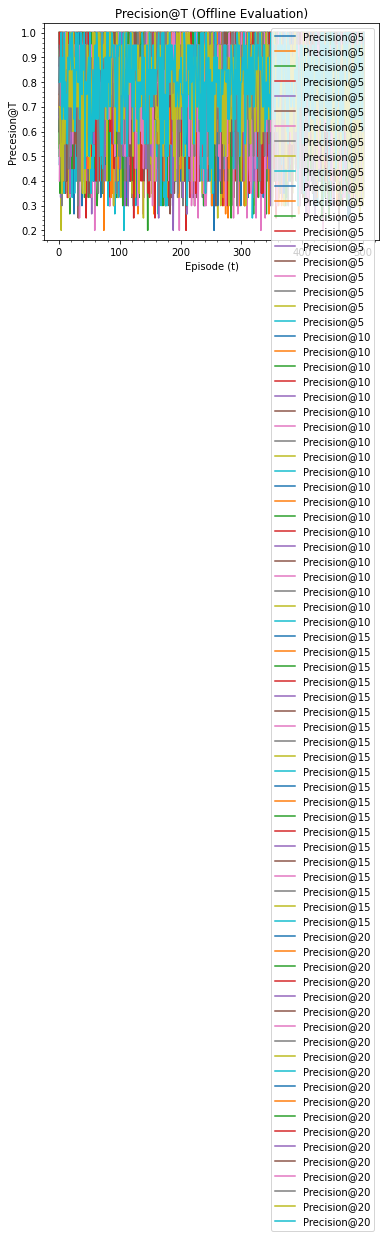

In [19]:
# PMF
for T_precision in T_precisions:
    pmf_Ts = []
    #for i in range(5): 
    for i in range(20):
        # Evaluate
        avg_precision = trainer.offline_pmf_evaluate(T_precision)

        # Append to list
        pmf_Ts.append(avg_precision)

    # Save data
    pmf_Ts = np.array(pmf_Ts)
    np.save(output_path + f'avg_precision@{T_precision}_offline_pmf_eval.npy', pmf_Ts)

    # Save
    sourceFile = open(output_path + f'avg_precision@{T_precision}_offline_pmf_eval.txt', 'w')
    print(f'Average Precision@{T_precision} (Eval): {np.mean(pmf_Ts)}', file=sourceFile)
    sourceFile.close()

Episode 20 | Precision@5 1.0 | Avg Precision@5 0.8800 | 
Episode 40 | Precision@5 1.0 | Avg Precision@5 0.8600 | 
Episode 60 | Precision@5 1.0 | Avg Precision@5 0.8467 | 
Episode 80 | Precision@5 1.0 | Avg Precision@5 0.8475 | 
Episode 100 | Precision@5 1.0 | Avg Precision@5 0.8540 | 
Episode 120 | Precision@5 1.0 | Avg Precision@5 0.8533 | 
Episode 140 | Precision@5 0.8 | Avg Precision@5 0.8557 | 
Episode 160 | Precision@5 1.0 | Avg Precision@5 0.8500 | 
Episode 180 | Precision@5 1.0 | Avg Precision@5 0.8411 | 
Episode 200 | Precision@5 1.0 | Avg Precision@5 0.8320 | 
Episode 220 | Precision@5 0.6 | Avg Precision@5 0.8318 | 
Episode 240 | Precision@5 1.0 | Avg Precision@5 0.8300 | 
Episode 260 | Precision@5 0.8 | Avg Precision@5 0.8292 | 
Episode 280 | Precision@5 1.0 | Avg Precision@5 0.8279 | 
Episode 300 | Precision@5 1.0 | Avg Precision@5 0.8320 | 
Episode 320 | Precision@5 1.0 | Avg Precision@5 0.8363 | 
Episode 340 | Precision@5 0.8 | Avg Precision@5 0.8388 | 
Episode 360 | Prec

Episode 260 | Precision@5 0.4 | Avg Precision@5 0.8115 | 
Episode 280 | Precision@5 1.0 | Avg Precision@5 0.8164 | 
Episode 300 | Precision@5 0.8 | Avg Precision@5 0.8193 | 
Episode 320 | Precision@5 1.0 | Avg Precision@5 0.8200 | 
Episode 340 | Precision@5 1.0 | Avg Precision@5 0.8176 | 
Episode 360 | Precision@5 1.0 | Avg Precision@5 0.8178 | 
Episode 380 | Precision@5 0.8 | Avg Precision@5 0.8205 | 
Episode 400 | Precision@5 1.0 | Avg Precision@5 0.8180 | 
Episode 420 | Precision@5 1.0 | Avg Precision@5 0.8186 | 
Episode 440 | Precision@5 1.0 | Avg Precision@5 0.8223 | 
Episode 460 | Precision@5 0.6 | Avg Precision@5 0.8217 | 
Episode 480 | Precision@5 0.4 | Avg Precision@5 0.8221 | 
Episode 500 | Precision@5 1.0 | Avg Precision@5 0.8224 | 
Offline Evaluation Finished
Average Precision@5: 0.8228 | 
Episode 20 | Precision@5 1.0 | Avg Precision@5 0.8800 | 
Episode 40 | Precision@5 1.0 | Avg Precision@5 0.8300 | 
Episode 60 | Precision@5 1.0 | Avg Precision@5 0.8333 | 
Episode 80 | Pre

Episode 500 | Precision@5 0.8 | Avg Precision@5 0.8312 | 
Offline Evaluation Finished
Average Precision@5: 0.8307 | 
Episode 20 | Precision@5 0.6 | Avg Precision@5 0.7700 | 
Episode 40 | Precision@5 0.6 | Avg Precision@5 0.7950 | 
Episode 60 | Precision@5 1.0 | Avg Precision@5 0.8167 | 
Episode 80 | Precision@5 1.0 | Avg Precision@5 0.8350 | 
Episode 100 | Precision@5 0.8 | Avg Precision@5 0.8280 | 
Episode 120 | Precision@5 0.8 | Avg Precision@5 0.8233 | 
Episode 140 | Precision@5 1.0 | Avg Precision@5 0.8329 | 
Episode 160 | Precision@5 1.0 | Avg Precision@5 0.8363 | 
Episode 180 | Precision@5 1.0 | Avg Precision@5 0.8367 | 
Episode 200 | Precision@5 0.8 | Avg Precision@5 0.8350 | 
Episode 220 | Precision@5 1.0 | Avg Precision@5 0.8300 | 
Episode 240 | Precision@5 1.0 | Avg Precision@5 0.8308 | 
Episode 260 | Precision@5 1.0 | Avg Precision@5 0.8323 | 
Episode 280 | Precision@5 1.0 | Avg Precision@5 0.8350 | 
Episode 300 | Precision@5 0.4 | Avg Precision@5 0.8393 | 
Episode 320 | Pre

Episode 220 | Precision@5 0.6 | Avg Precision@5 0.8273 | 
Episode 240 | Precision@5 1.0 | Avg Precision@5 0.8242 | 
Episode 260 | Precision@5 1.0 | Avg Precision@5 0.8192 | 
Episode 280 | Precision@5 0.8 | Avg Precision@5 0.8214 | 
Episode 300 | Precision@5 0.6 | Avg Precision@5 0.8253 | 
Episode 320 | Precision@5 1.0 | Avg Precision@5 0.8244 | 
Episode 340 | Precision@5 0.6 | Avg Precision@5 0.8247 | 
Episode 360 | Precision@5 1.0 | Avg Precision@5 0.8250 | 
Episode 380 | Precision@5 0.8 | Avg Precision@5 0.8253 | 
Episode 400 | Precision@5 0.8 | Avg Precision@5 0.8230 | 
Episode 420 | Precision@5 0.8 | Avg Precision@5 0.8224 | 
Episode 440 | Precision@5 1.0 | Avg Precision@5 0.8218 | 
Episode 460 | Precision@5 0.2 | Avg Precision@5 0.8174 | 
Episode 480 | Precision@5 0.8 | Avg Precision@5 0.8192 | 
Episode 500 | Precision@5 0.8 | Avg Precision@5 0.8204 | 
Offline Evaluation Finished
Average Precision@5: 0.8208 | 
Episode 20 | Precision@5 1.0 | Avg Precision@5 0.7700 | 
Episode 40 | P

Episode 470 | Precision@10 0.6 | Avg Precision@10 0.7457 | 
Episode 480 | Precision@10 0.8 | Avg Precision@10 0.7452 | 
Episode 490 | Precision@10 0.9 | Avg Precision@10 0.7471 | 
Episode 500 | Precision@10 1.0 | Avg Precision@10 0.7478 | 
Offline Evaluation Finished
Average Precision@10: 0.7477 | 
Episode 10 | Precision@10 0.7 | Avg Precision@10 0.7700 | 
Episode 20 | Precision@10 1.0 | Avg Precision@10 0.7700 | 
Episode 30 | Precision@10 0.6 | Avg Precision@10 0.7767 | 
Episode 40 | Precision@10 0.7 | Avg Precision@10 0.7650 | 
Episode 50 | Precision@10 1.0 | Avg Precision@10 0.7580 | 
Episode 60 | Precision@10 1.0 | Avg Precision@10 0.7683 | 
Episode 70 | Precision@10 0.8 | Avg Precision@10 0.7743 | 
Episode 80 | Precision@10 0.5 | Avg Precision@10 0.7800 | 
Episode 90 | Precision@10 0.7 | Avg Precision@10 0.7800 | 
Episode 100 | Precision@10 0.7 | Avg Precision@10 0.7810 | 
Episode 110 | Precision@10 0.5 | Avg Precision@10 0.7755 | 
Episode 120 | Precision@10 0.9 | Avg Precision@10

Episode 310 | Precision@10 0.7 | Avg Precision@10 0.7500 | 
Episode 320 | Precision@10 0.7 | Avg Precision@10 0.7497 | 
Episode 330 | Precision@10 0.9 | Avg Precision@10 0.7521 | 
Episode 340 | Precision@10 1.0 | Avg Precision@10 0.7524 | 
Episode 350 | Precision@10 0.8 | Avg Precision@10 0.7511 | 
Episode 360 | Precision@10 0.7 | Avg Precision@10 0.7481 | 
Episode 370 | Precision@10 0.5 | Avg Precision@10 0.7489 | 
Episode 380 | Precision@10 0.7 | Avg Precision@10 0.7479 | 
Episode 390 | Precision@10 0.4 | Avg Precision@10 0.7459 | 
Episode 400 | Precision@10 0.8 | Avg Precision@10 0.7465 | 
Episode 410 | Precision@10 0.9 | Avg Precision@10 0.7485 | 
Episode 420 | Precision@10 0.6 | Avg Precision@10 0.7493 | 
Episode 430 | Precision@10 0.8 | Avg Precision@10 0.7512 | 
Episode 440 | Precision@10 0.9 | Avg Precision@10 0.7534 | 
Episode 450 | Precision@10 0.5 | Avg Precision@10 0.7531 | 
Episode 460 | Precision@10 0.5 | Avg Precision@10 0.7496 | 
Episode 470 | Precision@10 1.0 | Avg Pre

Episode 150 | Precision@10 1.0 | Avg Precision@10 0.7573 | 
Episode 160 | Precision@10 0.8 | Avg Precision@10 0.7562 | 
Episode 170 | Precision@10 0.9 | Avg Precision@10 0.7553 | 
Episode 180 | Precision@10 0.6 | Avg Precision@10 0.7528 | 
Episode 190 | Precision@10 0.9 | Avg Precision@10 0.7532 | 
Episode 200 | Precision@10 0.5 | Avg Precision@10 0.7525 | 
Episode 210 | Precision@10 0.7 | Avg Precision@10 0.7524 | 
Episode 220 | Precision@10 1.0 | Avg Precision@10 0.7518 | 
Episode 230 | Precision@10 0.8 | Avg Precision@10 0.7504 | 
Episode 240 | Precision@10 0.5 | Avg Precision@10 0.7483 | 
Episode 250 | Precision@10 0.9 | Avg Precision@10 0.7496 | 
Episode 260 | Precision@10 0.8 | Avg Precision@10 0.7488 | 
Episode 270 | Precision@10 0.6 | Avg Precision@10 0.7481 | 
Episode 280 | Precision@10 0.6 | Avg Precision@10 0.7500 | 
Episode 290 | Precision@10 0.9 | Avg Precision@10 0.7524 | 
Episode 300 | Precision@10 0.7 | Avg Precision@10 0.7490 | 
Episode 310 | Precision@10 0.4 | Avg Pre

Episode 500 | Precision@10 0.7 | Avg Precision@10 0.7548 | 
Offline Evaluation Finished
Average Precision@10: 0.7551 | 
Episode 10 | Precision@10 0.6 | Avg Precision@10 0.7100 | 
Episode 20 | Precision@10 0.9 | Avg Precision@10 0.7450 | 
Episode 30 | Precision@10 0.7 | Avg Precision@10 0.7533 | 
Episode 40 | Precision@10 0.9 | Avg Precision@10 0.7775 | 
Episode 50 | Precision@10 0.7 | Avg Precision@10 0.7780 | 
Episode 60 | Precision@10 0.8 | Avg Precision@10 0.7833 | 
Episode 70 | Precision@10 0.5 | Avg Precision@10 0.7786 | 
Episode 80 | Precision@10 0.3 | Avg Precision@10 0.7663 | 
Episode 90 | Precision@10 0.8 | Avg Precision@10 0.7678 | 
Episode 100 | Precision@10 0.8 | Avg Precision@10 0.7620 | 
Episode 110 | Precision@10 0.5 | Avg Precision@10 0.7618 | 
Episode 120 | Precision@10 0.8 | Avg Precision@10 0.7633 | 
Episode 130 | Precision@10 0.9 | Avg Precision@10 0.7592 | 
Episode 140 | Precision@10 0.9 | Avg Precision@10 0.7593 | 
Episode 150 | Precision@10 0.7 | Avg Precision@10

Episode 340 | Precision@10 0.7 | Avg Precision@10 0.7565 | 
Episode 350 | Precision@10 0.6 | Avg Precision@10 0.7577 | 
Episode 360 | Precision@10 0.8 | Avg Precision@10 0.7572 | 
Episode 370 | Precision@10 0.7 | Avg Precision@10 0.7559 | 
Episode 380 | Precision@10 0.4 | Avg Precision@10 0.7547 | 
Episode 390 | Precision@10 0.9 | Avg Precision@10 0.7554 | 
Episode 400 | Precision@10 0.7 | Avg Precision@10 0.7570 | 
Episode 410 | Precision@10 0.8 | Avg Precision@10 0.7585 | 
Episode 420 | Precision@10 0.7 | Avg Precision@10 0.7602 | 
Episode 430 | Precision@10 1.0 | Avg Precision@10 0.7605 | 
Episode 440 | Precision@10 0.5 | Avg Precision@10 0.7616 | 
Episode 450 | Precision@10 0.9 | Avg Precision@10 0.7604 | 
Episode 460 | Precision@10 0.7 | Avg Precision@10 0.7602 | 
Episode 470 | Precision@10 0.5 | Avg Precision@10 0.7606 | 
Episode 480 | Precision@10 0.9 | Avg Precision@10 0.7600 | 
Episode 490 | Precision@10 0.5 | Avg Precision@10 0.7594 | 
Episode 500 | Precision@10 0.4 | Avg Pre

Episode 180 | Precision@10 0.9 | Avg Precision@10 0.7661 | 
Episode 190 | Precision@10 0.6 | Avg Precision@10 0.7668 | 
Episode 200 | Precision@10 1.0 | Avg Precision@10 0.7655 | 
Episode 210 | Precision@10 0.8 | Avg Precision@10 0.7671 | 
Episode 220 | Precision@10 0.9 | Avg Precision@10 0.7659 | 
Episode 230 | Precision@10 0.7 | Avg Precision@10 0.7596 | 
Episode 240 | Precision@10 1.0 | Avg Precision@10 0.7592 | 
Episode 250 | Precision@10 1.0 | Avg Precision@10 0.7596 | 
Episode 260 | Precision@10 1.0 | Avg Precision@10 0.7562 | 
Episode 270 | Precision@10 0.8 | Avg Precision@10 0.7522 | 
Episode 280 | Precision@10 0.9 | Avg Precision@10 0.7532 | 
Episode 290 | Precision@10 0.4 | Avg Precision@10 0.7534 | 
Episode 300 | Precision@10 0.7 | Avg Precision@10 0.7553 | 
Episode 310 | Precision@10 1.0 | Avg Precision@10 0.7535 | 
Episode 320 | Precision@10 1.0 | Avg Precision@10 0.7503 | 
Episode 330 | Precision@10 0.8 | Avg Precision@10 0.7512 | 
Episode 340 | Precision@10 1.0 | Avg Pre

Episode 20 | Precision@10 1.0 | Avg Precision@10 0.8100 | 
Episode 30 | Precision@10 0.8 | Avg Precision@10 0.7900 | 
Episode 40 | Precision@10 0.7 | Avg Precision@10 0.7950 | 
Episode 50 | Precision@10 0.7 | Avg Precision@10 0.7740 | 
Episode 60 | Precision@10 0.9 | Avg Precision@10 0.7617 | 
Episode 70 | Precision@10 0.6 | Avg Precision@10 0.7457 | 
Episode 80 | Precision@10 0.8 | Avg Precision@10 0.7325 | 
Episode 90 | Precision@10 0.5 | Avg Precision@10 0.7322 | 
Episode 100 | Precision@10 0.9 | Avg Precision@10 0.7390 | 
Episode 110 | Precision@10 0.9 | Avg Precision@10 0.7373 | 
Episode 120 | Precision@10 0.6 | Avg Precision@10 0.7417 | 
Episode 130 | Precision@10 1.0 | Avg Precision@10 0.7392 | 
Episode 140 | Precision@10 0.4 | Avg Precision@10 0.7429 | 
Episode 150 | Precision@10 0.9 | Avg Precision@10 0.7420 | 
Episode 160 | Precision@10 0.9 | Avg Precision@10 0.7444 | 
Episode 170 | Precision@10 0.8 | Avg Precision@10 0.7471 | 
Episode 180 | Precision@10 0.5 | Avg Precision@1

Episode 370 | Precision@10 0.7 | Avg Precision@10 0.7524 | 
Episode 380 | Precision@10 0.6 | Avg Precision@10 0.7539 | 
Episode 390 | Precision@10 1.0 | Avg Precision@10 0.7562 | 
Episode 400 | Precision@10 0.8 | Avg Precision@10 0.7550 | 
Episode 410 | Precision@10 0.9 | Avg Precision@10 0.7544 | 
Episode 420 | Precision@10 0.6 | Avg Precision@10 0.7550 | 
Episode 430 | Precision@10 0.7 | Avg Precision@10 0.7540 | 
Episode 440 | Precision@10 0.9 | Avg Precision@10 0.7548 | 
Episode 450 | Precision@10 0.9 | Avg Precision@10 0.7549 | 
Episode 460 | Precision@10 0.6 | Avg Precision@10 0.7548 | 
Episode 470 | Precision@10 0.7 | Avg Precision@10 0.7551 | 
Episode 480 | Precision@10 0.8 | Avg Precision@10 0.7569 | 
Episode 490 | Precision@10 0.9 | Avg Precision@10 0.7578 | 
Episode 500 | Precision@10 0.9 | Avg Precision@10 0.7574 | 
Offline Evaluation Finished
Average Precision@10: 0.7575 | 
Episode 20 | Precision@15 0.9333333333333333 | Avg Precision@15 0.7667 | 
Episode 40 | Precision@15 

Episode 40 | Precision@15 0.7333333333333333 | Avg Precision@15 0.7383 | 
Episode 60 | Precision@15 0.8 | Avg Precision@15 0.7656 | 
Episode 80 | Precision@15 0.7333333333333333 | Avg Precision@15 0.7742 | 
Episode 100 | Precision@15 1.0 | Avg Precision@15 0.7647 | 
Episode 120 | Precision@15 0.6 | Avg Precision@15 0.7606 | 
Episode 140 | Precision@15 0.6 | Avg Precision@15 0.7552 | 
Episode 160 | Precision@15 0.8666666666666667 | Avg Precision@15 0.7579 | 
Episode 180 | Precision@15 0.26666666666666666 | Avg Precision@15 0.7467 | 
Episode 200 | Precision@15 0.7333333333333333 | Avg Precision@15 0.7457 | 
Episode 220 | Precision@15 0.6666666666666666 | Avg Precision@15 0.7430 | 
Episode 240 | Precision@15 0.8 | Avg Precision@15 0.7436 | 
Episode 260 | Precision@15 0.6 | Avg Precision@15 0.7428 | 
Episode 280 | Precision@15 0.8 | Avg Precision@15 0.7426 | 
Episode 300 | Precision@15 0.6666666666666666 | Avg Precision@15 0.7469 | 
Episode 320 | Precision@15 0.5333333333333333 | Avg Preci

Episode 320 | Precision@15 0.7333333333333333 | Avg Precision@15 0.7358 | 
Episode 340 | Precision@15 0.6 | Avg Precision@15 0.7335 | 
Episode 360 | Precision@15 0.6666666666666666 | Avg Precision@15 0.7328 | 
Episode 380 | Precision@15 1.0 | Avg Precision@15 0.7339 | 
Episode 400 | Precision@15 0.9333333333333333 | Avg Precision@15 0.7365 | 
Episode 420 | Precision@15 0.7333333333333333 | Avg Precision@15 0.7340 | 
Episode 440 | Precision@15 0.8 | Avg Precision@15 0.7350 | 
Episode 460 | Precision@15 0.4 | Avg Precision@15 0.7343 | 
Episode 480 | Precision@15 1.0 | Avg Precision@15 0.7367 | 
Episode 500 | Precision@15 0.5333333333333333 | Avg Precision@15 0.7364 | 
Offline Evaluation Finished
Average Precision@15: 0.7357 | 
Episode 20 | Precision@15 0.8666666666666667 | Avg Precision@15 0.7933 | 
Episode 40 | Precision@15 0.7333333333333333 | Avg Precision@15 0.7983 | 
Episode 60 | Precision@15 0.4666666666666667 | Avg Precision@15 0.7856 | 
Episode 80 | Precision@15 0.533333333333333

Episode 80 | Precision@15 1.0 | Avg Precision@15 0.6850 | 
Episode 100 | Precision@15 0.8666666666666667 | Avg Precision@15 0.6887 | 
Episode 120 | Precision@15 0.8 | Avg Precision@15 0.6933 | 
Episode 140 | Precision@15 0.7333333333333333 | Avg Precision@15 0.7029 | 
Episode 160 | Precision@15 0.5333333333333333 | Avg Precision@15 0.6983 | 
Episode 180 | Precision@15 0.4 | Avg Precision@15 0.7048 | 
Episode 200 | Precision@15 0.6666666666666666 | Avg Precision@15 0.7067 | 
Episode 220 | Precision@15 0.6666666666666666 | Avg Precision@15 0.7070 | 
Episode 240 | Precision@15 0.4 | Avg Precision@15 0.7100 | 
Episode 260 | Precision@15 0.7333333333333333 | Avg Precision@15 0.7151 | 
Episode 280 | Precision@15 0.8 | Avg Precision@15 0.7117 | 
Episode 300 | Precision@15 0.5333333333333333 | Avg Precision@15 0.7109 | 
Episode 320 | Precision@15 0.6 | Avg Precision@15 0.7146 | 
Episode 340 | Precision@15 0.5333333333333333 | Avg Precision@15 0.7182 | 
Episode 360 | Precision@15 0.866666666666

Episode 360 | Precision@15 0.6666666666666666 | Avg Precision@15 0.7300 | 
Episode 380 | Precision@15 0.5333333333333333 | Avg Precision@15 0.7298 | 
Episode 400 | Precision@15 0.9333333333333333 | Avg Precision@15 0.7327 | 
Episode 420 | Precision@15 0.6 | Avg Precision@15 0.7346 | 
Episode 440 | Precision@15 0.8666666666666667 | Avg Precision@15 0.7352 | 
Episode 460 | Precision@15 0.7333333333333333 | Avg Precision@15 0.7346 | 
Episode 480 | Precision@15 0.7333333333333333 | Avg Precision@15 0.7371 | 
Episode 500 | Precision@15 0.7333333333333333 | Avg Precision@15 0.7383 | 
Offline Evaluation Finished
Average Precision@15: 0.7381 | 
Episode 20 | Precision@15 0.7333333333333333 | Avg Precision@15 0.7033 | 
Episode 40 | Precision@15 0.8666666666666667 | Avg Precision@15 0.7083 | 
Episode 60 | Precision@15 0.7333333333333333 | Avg Precision@15 0.7156 | 
Episode 80 | Precision@15 0.6 | Avg Precision@15 0.7208 | 
Episode 100 | Precision@15 0.8 | Avg Precision@15 0.7300 | 
Episode 120 | 

Episode 335 | Precision@20 0.85 | Avg Precision@20 0.7481 | 
Episode 340 | Precision@20 0.6 | Avg Precision@20 0.7478 | 
Episode 345 | Precision@20 1.0 | Avg Precision@20 0.7481 | 
Episode 350 | Precision@20 0.55 | Avg Precision@20 0.7481 | 
Episode 355 | Precision@20 0.95 | Avg Precision@20 0.7499 | 
Episode 360 | Precision@20 0.7 | Avg Precision@20 0.7510 | 
Episode 365 | Precision@20 0.95 | Avg Precision@20 0.7514 | 
Episode 370 | Precision@20 0.85 | Avg Precision@20 0.7519 | 
Episode 375 | Precision@20 0.9 | Avg Precision@20 0.7537 | 
Episode 380 | Precision@20 0.7 | Avg Precision@20 0.7538 | 
Episode 385 | Precision@20 0.8 | Avg Precision@20 0.7544 | 
Episode 390 | Precision@20 0.6 | Avg Precision@20 0.7553 | 
Episode 395 | Precision@20 0.55 | Avg Precision@20 0.7542 | 
Episode 400 | Precision@20 0.5 | Avg Precision@20 0.7542 | 
Episode 405 | Precision@20 0.5 | Avg Precision@20 0.7536 | 
Episode 410 | Precision@20 0.65 | Avg Precision@20 0.7538 | 
Episode 415 | Precision@20 0.7 | 

Episode 5 | Precision@20 0.9 | Avg Precision@20 0.7400 | 
Episode 10 | Precision@20 0.8 | Avg Precision@20 0.7500 | 
Episode 15 | Precision@20 0.7 | Avg Precision@20 0.7133 | 
Episode 20 | Precision@20 0.8 | Avg Precision@20 0.7375 | 
Episode 25 | Precision@20 0.95 | Avg Precision@20 0.7480 | 
Episode 30 | Precision@20 0.8 | Avg Precision@20 0.7417 | 
Episode 35 | Precision@20 0.9 | Avg Precision@20 0.7386 | 
Episode 40 | Precision@20 0.7 | Avg Precision@20 0.7412 | 
Episode 45 | Precision@20 0.6 | Avg Precision@20 0.7167 | 
Episode 50 | Precision@20 0.65 | Avg Precision@20 0.7080 | 
Episode 55 | Precision@20 0.55 | Avg Precision@20 0.7055 | 
Episode 60 | Precision@20 0.6 | Avg Precision@20 0.7017 | 
Episode 65 | Precision@20 0.8 | Avg Precision@20 0.7069 | 
Episode 70 | Precision@20 0.6 | Avg Precision@20 0.7064 | 
Episode 75 | Precision@20 0.95 | Avg Precision@20 0.7060 | 
Episode 80 | Precision@20 0.7 | Avg Precision@20 0.7063 | 
Episode 85 | Precision@20 0.9 | Avg Precision@20 0.70

Episode 185 | Precision@20 0.9 | Avg Precision@20 0.7565 | 
Episode 190 | Precision@20 0.5 | Avg Precision@20 0.7566 | 
Episode 195 | Precision@20 0.55 | Avg Precision@20 0.7564 | 
Episode 200 | Precision@20 0.75 | Avg Precision@20 0.7538 | 
Episode 205 | Precision@20 0.85 | Avg Precision@20 0.7544 | 
Episode 210 | Precision@20 0.7 | Avg Precision@20 0.7536 | 
Episode 215 | Precision@20 0.65 | Avg Precision@20 0.7530 | 
Episode 220 | Precision@20 0.75 | Avg Precision@20 0.7523 | 
Episode 225 | Precision@20 0.7 | Avg Precision@20 0.7529 | 
Episode 230 | Precision@20 0.55 | Avg Precision@20 0.7502 | 
Episode 235 | Precision@20 0.6 | Avg Precision@20 0.7498 | 
Episode 240 | Precision@20 0.9 | Avg Precision@20 0.7494 | 
Episode 245 | Precision@20 0.6 | Avg Precision@20 0.7494 | 
Episode 250 | Precision@20 0.8 | Avg Precision@20 0.7494 | 
Episode 255 | Precision@20 0.8 | Avg Precision@20 0.7516 | 
Episode 260 | Precision@20 0.8 | Avg Precision@20 0.7525 | 
Episode 265 | Precision@20 0.65 | 

Episode 360 | Precision@20 0.7 | Avg Precision@20 0.7290 | 
Episode 365 | Precision@20 0.65 | Avg Precision@20 0.7288 | 
Episode 370 | Precision@20 0.75 | Avg Precision@20 0.7300 | 
Episode 375 | Precision@20 0.75 | Avg Precision@20 0.7272 | 
Episode 380 | Precision@20 0.65 | Avg Precision@20 0.7266 | 
Episode 385 | Precision@20 0.75 | Avg Precision@20 0.7277 | 
Episode 390 | Precision@20 0.75 | Avg Precision@20 0.7273 | 
Episode 395 | Precision@20 0.9 | Avg Precision@20 0.7278 | 
Episode 400 | Precision@20 0.7 | Avg Precision@20 0.7275 | 
Episode 405 | Precision@20 0.9 | Avg Precision@20 0.7278 | 
Episode 410 | Precision@20 0.7 | Avg Precision@20 0.7270 | 
Episode 415 | Precision@20 0.95 | Avg Precision@20 0.7277 | 
Episode 420 | Precision@20 1.0 | Avg Precision@20 0.7275 | 
Episode 425 | Precision@20 0.9 | Avg Precision@20 0.7285 | 
Episode 430 | Precision@20 0.9 | Avg Precision@20 0.7303 | 
Episode 435 | Precision@20 0.9 | Avg Precision@20 0.7310 | 
Episode 440 | Precision@20 0.8 | 

Episode 30 | Precision@20 0.5 | Avg Precision@20 0.7100 | 
Episode 35 | Precision@20 0.55 | Avg Precision@20 0.7100 | 
Episode 40 | Precision@20 0.6 | Avg Precision@20 0.7150 | 
Episode 45 | Precision@20 0.75 | Avg Precision@20 0.7244 | 
Episode 50 | Precision@20 0.9 | Avg Precision@20 0.7220 | 
Episode 55 | Precision@20 0.45 | Avg Precision@20 0.7164 | 
Episode 60 | Precision@20 0.65 | Avg Precision@20 0.7083 | 
Episode 65 | Precision@20 0.7 | Avg Precision@20 0.7038 | 
Episode 70 | Precision@20 0.7 | Avg Precision@20 0.7014 | 
Episode 75 | Precision@20 0.75 | Avg Precision@20 0.7033 | 
Episode 80 | Precision@20 0.8 | Avg Precision@20 0.7119 | 
Episode 85 | Precision@20 0.55 | Avg Precision@20 0.7159 | 
Episode 90 | Precision@20 0.65 | Avg Precision@20 0.7156 | 
Episode 95 | Precision@20 0.7 | Avg Precision@20 0.7195 | 
Episode 100 | Precision@20 0.9 | Avg Precision@20 0.7255 | 
Episode 105 | Precision@20 0.85 | Avg Precision@20 0.7262 | 
Episode 110 | Precision@20 0.7 | Avg Precision

Episode 210 | Precision@20 0.95 | Avg Precision@20 0.7448 | 
Episode 215 | Precision@20 0.7 | Avg Precision@20 0.7451 | 
Episode 220 | Precision@20 1.0 | Avg Precision@20 0.7455 | 
Episode 225 | Precision@20 0.4 | Avg Precision@20 0.7422 | 
Episode 230 | Precision@20 0.9 | Avg Precision@20 0.7437 | 
Episode 235 | Precision@20 0.7 | Avg Precision@20 0.7415 | 
Episode 240 | Precision@20 0.8 | Avg Precision@20 0.7413 | 
Episode 245 | Precision@20 0.7 | Avg Precision@20 0.7420 | 
Episode 250 | Precision@20 0.7 | Avg Precision@20 0.7428 | 
Episode 255 | Precision@20 0.75 | Avg Precision@20 0.7437 | 
Episode 260 | Precision@20 0.85 | Avg Precision@20 0.7438 | 
Episode 265 | Precision@20 0.55 | Avg Precision@20 0.7409 | 
Episode 270 | Precision@20 0.7 | Avg Precision@20 0.7415 | 
Episode 275 | Precision@20 0.75 | Avg Precision@20 0.7418 | 
Episode 280 | Precision@20 0.8 | Avg Precision@20 0.7429 | 
Episode 285 | Precision@20 0.55 | Avg Precision@20 0.7409 | 
Episode 290 | Precision@20 0.7 | A

Episode 385 | Precision@20 0.8 | Avg Precision@20 0.7348 | 
Episode 390 | Precision@20 0.95 | Avg Precision@20 0.7360 | 
Episode 395 | Precision@20 0.7 | Avg Precision@20 0.7371 | 
Episode 400 | Precision@20 0.8 | Avg Precision@20 0.7369 | 
Episode 405 | Precision@20 0.35 | Avg Precision@20 0.7348 | 
Episode 410 | Precision@20 0.85 | Avg Precision@20 0.7354 | 
Episode 415 | Precision@20 0.85 | Avg Precision@20 0.7364 | 
Episode 420 | Precision@20 0.45 | Avg Precision@20 0.7358 | 
Episode 425 | Precision@20 0.95 | Avg Precision@20 0.7349 | 
Episode 430 | Precision@20 0.95 | Avg Precision@20 0.7348 | 
Episode 435 | Precision@20 0.95 | Avg Precision@20 0.7352 | 
Episode 440 | Precision@20 0.6 | Avg Precision@20 0.7349 | 
Episode 445 | Precision@20 0.8 | Avg Precision@20 0.7346 | 
Episode 450 | Precision@20 0.45 | Avg Precision@20 0.7353 | 
Episode 455 | Precision@20 0.85 | Avg Precision@20 0.7352 | 
Episode 460 | Precision@20 0.8 | Avg Precision@20 0.7352 | 
Episode 465 | Precision@20 0.8

Episode 60 | Precision@20 0.6 | Avg Precision@20 0.7458 | 
Episode 65 | Precision@20 0.85 | Avg Precision@20 0.7508 | 
Episode 70 | Precision@20 0.7 | Avg Precision@20 0.7479 | 
Episode 75 | Precision@20 0.55 | Avg Precision@20 0.7380 | 
Episode 80 | Precision@20 0.65 | Avg Precision@20 0.7375 | 
Episode 85 | Precision@20 0.5 | Avg Precision@20 0.7400 | 
Episode 90 | Precision@20 0.7 | Avg Precision@20 0.7372 | 
Episode 95 | Precision@20 0.75 | Avg Precision@20 0.7379 | 
Episode 100 | Precision@20 0.85 | Avg Precision@20 0.7400 | 
Episode 105 | Precision@20 0.5 | Avg Precision@20 0.7343 | 
Episode 110 | Precision@20 0.9 | Avg Precision@20 0.7373 | 
Episode 115 | Precision@20 0.7 | Avg Precision@20 0.7391 | 
Episode 120 | Precision@20 0.6 | Avg Precision@20 0.7354 | 
Episode 125 | Precision@20 0.85 | Avg Precision@20 0.7356 | 
Episode 130 | Precision@20 0.85 | Avg Precision@20 0.7400 | 
Episode 135 | Precision@20 0.65 | Avg Precision@20 0.7389 | 
Episode 140 | Precision@20 0.35 | Avg Pr

Episode 235 | Precision@20 0.85 | Avg Precision@20 0.7245 | 
Episode 240 | Precision@20 0.9 | Avg Precision@20 0.7242 | 
Episode 245 | Precision@20 0.75 | Avg Precision@20 0.7261 | 
Episode 250 | Precision@20 0.95 | Avg Precision@20 0.7258 | 
Episode 255 | Precision@20 0.95 | Avg Precision@20 0.7259 | 
Episode 260 | Precision@20 0.85 | Avg Precision@20 0.7263 | 
Episode 265 | Precision@20 0.55 | Avg Precision@20 0.7268 | 
Episode 270 | Precision@20 0.45 | Avg Precision@20 0.7267 | 
Episode 275 | Precision@20 0.65 | Avg Precision@20 0.7276 | 
Episode 280 | Precision@20 0.9 | Avg Precision@20 0.7273 | 
Episode 285 | Precision@20 0.8 | Avg Precision@20 0.7270 | 
Episode 290 | Precision@20 0.75 | Avg Precision@20 0.7262 | 
Episode 295 | Precision@20 0.75 | Avg Precision@20 0.7261 | 
Episode 300 | Precision@20 0.9 | Avg Precision@20 0.7263 | 
Episode 305 | Precision@20 0.8 | Avg Precision@20 0.7267 | 
Episode 310 | Precision@20 0.65 | Avg Precision@20 0.7285 | 
Episode 315 | Precision@20 0.

Episode 410 | Precision@20 0.95 | Avg Precision@20 0.7423 | 
Episode 415 | Precision@20 0.3 | Avg Precision@20 0.7420 | 
Episode 420 | Precision@20 0.9 | Avg Precision@20 0.7426 | 
Episode 425 | Precision@20 0.75 | Avg Precision@20 0.7419 | 
Episode 430 | Precision@20 0.6 | Avg Precision@20 0.7417 | 
Episode 435 | Precision@20 0.75 | Avg Precision@20 0.7425 | 
Episode 440 | Precision@20 0.85 | Avg Precision@20 0.7422 | 
Episode 445 | Precision@20 0.7 | Avg Precision@20 0.7417 | 
Episode 450 | Precision@20 0.85 | Avg Precision@20 0.7411 | 
Episode 455 | Precision@20 0.95 | Avg Precision@20 0.7430 | 
Episode 460 | Precision@20 0.75 | Avg Precision@20 0.7427 | 
Episode 465 | Precision@20 0.8 | Avg Precision@20 0.7431 | 
Episode 470 | Precision@20 0.85 | Avg Precision@20 0.7434 | 
Episode 475 | Precision@20 0.7 | Avg Precision@20 0.7439 | 
Episode 480 | Precision@20 0.85 | Avg Precision@20 0.7441 | 
Episode 485 | Precision@20 0.5 | Avg Precision@20 0.7435 | 
Episode 490 | Precision@20 0.85

Episode 80 | Precision@20 0.7 | Avg Precision@20 0.7544 | 
Episode 85 | Precision@20 0.55 | Avg Precision@20 0.7518 | 
Episode 90 | Precision@20 0.9 | Avg Precision@20 0.7450 | 
Episode 95 | Precision@20 0.65 | Avg Precision@20 0.7463 | 
Episode 100 | Precision@20 0.7 | Avg Precision@20 0.7420 | 
Episode 105 | Precision@20 0.85 | Avg Precision@20 0.7429 | 
Episode 110 | Precision@20 0.85 | Avg Precision@20 0.7432 | 
Episode 115 | Precision@20 0.9 | Avg Precision@20 0.7387 | 
Episode 120 | Precision@20 0.95 | Avg Precision@20 0.7375 | 
Episode 125 | Precision@20 0.65 | Avg Precision@20 0.7348 | 
Episode 130 | Precision@20 0.85 | Avg Precision@20 0.7354 | 
Episode 135 | Precision@20 0.5 | Avg Precision@20 0.7304 | 
Episode 140 | Precision@20 0.85 | Avg Precision@20 0.7325 | 
Episode 145 | Precision@20 0.15 | Avg Precision@20 0.7286 | 
Episode 150 | Precision@20 0.3 | Avg Precision@20 0.7243 | 
Episode 155 | Precision@20 0.75 | Avg Precision@20 0.7258 | 
Episode 160 | Precision@20 0.75 | 

Episode 255 | Precision@20 0.35 | Avg Precision@20 0.7225 | 
Episode 260 | Precision@20 0.25 | Avg Precision@20 0.7210 | 
Episode 265 | Precision@20 1.0 | Avg Precision@20 0.7228 | 
Episode 270 | Precision@20 0.6 | Avg Precision@20 0.7228 | 
Episode 275 | Precision@20 0.8 | Avg Precision@20 0.7224 | 
Episode 280 | Precision@20 0.65 | Avg Precision@20 0.7225 | 
Episode 285 | Precision@20 0.65 | Avg Precision@20 0.7223 | 
Episode 290 | Precision@20 0.8 | Avg Precision@20 0.7212 | 
Episode 295 | Precision@20 0.7 | Avg Precision@20 0.7215 | 
Episode 300 | Precision@20 0.8 | Avg Precision@20 0.7210 | 
Episode 305 | Precision@20 0.8 | Avg Precision@20 0.7223 | 
Episode 310 | Precision@20 1.0 | Avg Precision@20 0.7235 | 
Episode 315 | Precision@20 1.0 | Avg Precision@20 0.7263 | 
Episode 320 | Precision@20 0.5 | Avg Precision@20 0.7244 | 
Episode 325 | Precision@20 0.9 | Avg Precision@20 0.7254 | 
Episode 330 | Precision@20 0.7 | Avg Precision@20 0.7261 | 
Episode 335 | Precision@20 0.7 | Avg

Episode 430 | Precision@20 0.65 | Avg Precision@20 0.7344 | 
Episode 435 | Precision@20 0.85 | Avg Precision@20 0.7356 | 
Episode 440 | Precision@20 0.75 | Avg Precision@20 0.7362 | 
Episode 445 | Precision@20 0.6 | Avg Precision@20 0.7355 | 
Episode 450 | Precision@20 0.95 | Avg Precision@20 0.7362 | 
Episode 455 | Precision@20 0.65 | Avg Precision@20 0.7357 | 
Episode 460 | Precision@20 0.8 | Avg Precision@20 0.7370 | 
Episode 465 | Precision@20 0.75 | Avg Precision@20 0.7378 | 
Episode 470 | Precision@20 1.0 | Avg Precision@20 0.7388 | 
Episode 475 | Precision@20 0.95 | Avg Precision@20 0.7385 | 
Episode 480 | Precision@20 0.95 | Avg Precision@20 0.7391 | 
Episode 485 | Precision@20 1.0 | Avg Precision@20 0.7395 | 
Episode 490 | Precision@20 0.75 | Avg Precision@20 0.7401 | 
Episode 495 | Precision@20 0.95 | Avg Precision@20 0.7413 | 
Episode 500 | Precision@20 0.8 | Avg Precision@20 0.7425 | 
Offline Evaluation Finished
Average Precision@20: 0.7429 | 
Episode 5 | Precision@20 0.9 |

Episode 105 | Precision@20 0.6 | Avg Precision@20 0.7510 | 
Episode 110 | Precision@20 0.85 | Avg Precision@20 0.7491 | 
Episode 115 | Precision@20 0.9 | Avg Precision@20 0.7500 | 
Episode 120 | Precision@20 0.85 | Avg Precision@20 0.7508 | 
Episode 125 | Precision@20 0.85 | Avg Precision@20 0.7532 | 
Episode 130 | Precision@20 0.8 | Avg Precision@20 0.7523 | 
Episode 135 | Precision@20 0.5 | Avg Precision@20 0.7459 | 
Episode 140 | Precision@20 0.8 | Avg Precision@20 0.7443 | 
Episode 145 | Precision@20 0.65 | Avg Precision@20 0.7414 | 
Episode 150 | Precision@20 0.9 | Avg Precision@20 0.7400 | 
Episode 155 | Precision@20 0.9 | Avg Precision@20 0.7416 | 
Episode 160 | Precision@20 0.9 | Avg Precision@20 0.7444 | 
Episode 165 | Precision@20 0.85 | Avg Precision@20 0.7479 | 
Episode 170 | Precision@20 0.5 | Avg Precision@20 0.7438 | 
Episode 175 | Precision@20 0.8 | Avg Precision@20 0.7420 | 
Episode 180 | Precision@20 0.8 | Avg Precision@20 0.7431 | 
Episode 185 | Precision@20 0.8 | Av

Episode 280 | Precision@20 0.9 | Avg Precision@20 0.7336 | 
Episode 285 | Precision@20 0.6 | Avg Precision@20 0.7319 | 
Episode 290 | Precision@20 0.6 | Avg Precision@20 0.7316 | 
Episode 295 | Precision@20 0.85 | Avg Precision@20 0.7334 | 
Episode 300 | Precision@20 0.55 | Avg Precision@20 0.7327 | 
Episode 305 | Precision@20 0.95 | Avg Precision@20 0.7341 | 
Episode 310 | Precision@20 0.85 | Avg Precision@20 0.7331 | 
Episode 315 | Precision@20 0.75 | Avg Precision@20 0.7335 | 
Episode 320 | Precision@20 0.75 | Avg Precision@20 0.7328 | 
Episode 325 | Precision@20 0.8 | Avg Precision@20 0.7325 | 
Episode 330 | Precision@20 0.75 | Avg Precision@20 0.7338 | 
Episode 335 | Precision@20 0.65 | Avg Precision@20 0.7339 | 
Episode 340 | Precision@20 0.85 | Avg Precision@20 0.7353 | 
Episode 345 | Precision@20 0.95 | Avg Precision@20 0.7339 | 
Episode 350 | Precision@20 0.95 | Avg Precision@20 0.7339 | 
Episode 355 | Precision@20 0.6 | Avg Precision@20 0.7331 | 
Episode 360 | Precision@20 0.

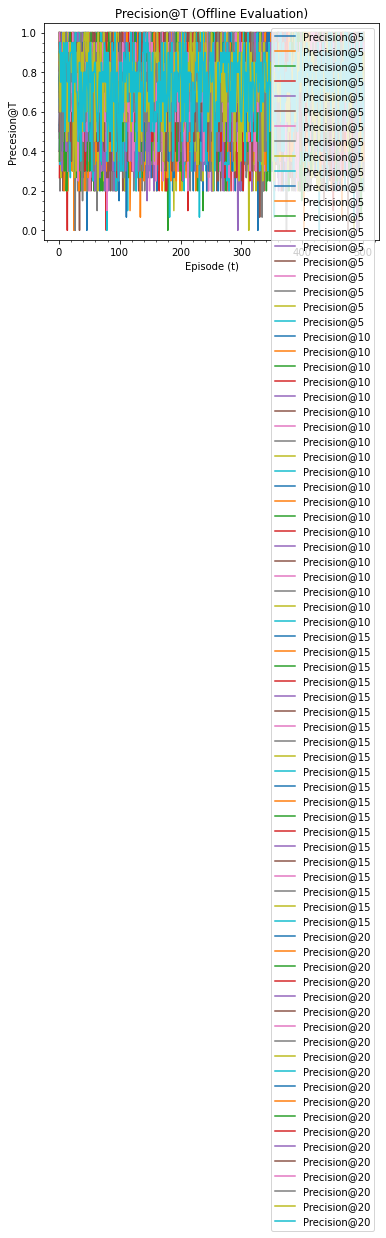

In [20]:
# DRR
for T_precision in T_precisions:
    drr_Ts = []
    #for i in range(5):
    for i in range(20):
        # Evaluate
        avg_precision = trainer.offline_evaluate(T_precision)

        # Append to list
        drr_Ts.append(avg_precision)

    # Save data
    drr_Ts = np.array(drr_Ts)
    np.save(output_path + f'avg_precision@{T_precision}_offline_eval.npy', drr_Ts)

    # Save
    sourceFile = open(output_path + f'avg_precision@{T_precision}_offline_eval.txt', 'w')
    print(f'Average Precision@{T_precision} (Eval): {np.mean(drr_Ts)}', file=sourceFile)
    sourceFile.close()

In [21]:
pmf_fives = np.load(output_path + 'avg_precision@5_offline_pmf_eval.npy')
pmf_tens = np.load(output_path + 'avg_precision@10_offline_pmf_eval.npy')
pmf_fifteens = np.load(output_path + 'avg_precision@15_offline_pmf_eval.npy')
pmf_twenties = np.load(output_path + 'avg_precision@20_offline_pmf_eval.npy')

drr_fives = np.load(output_path + 'avg_precision@5_offline_eval.npy')
drr_tens = np.load(output_path + 'avg_precision@10_offline_eval.npy')
drr_fifteens = np.load(output_path + 'avg_precision@15_offline_eval.npy')
drr_twenties = np.load(output_path + 'avg_precision@20_offline_eval.npy')

[0.9067265469061878, 0.8179540918163672, 0.8020691949434464, 0.7948702594810378]
[0.005657230326151452, 0.006809715530671094, 0.007787043706919303, 0.006847820227049241]
[0.8321756487025949, 0.7554491017964071, 0.7394078509647374, 0.7390169660678642]
[0.008715403783789332, 0.004894332052191261, 0.005972964726151136, 0.005997786037932951]


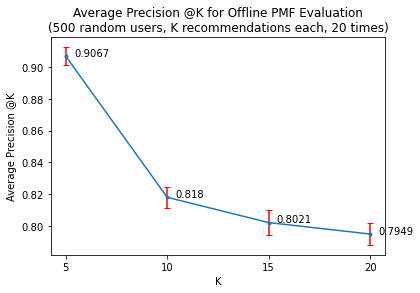

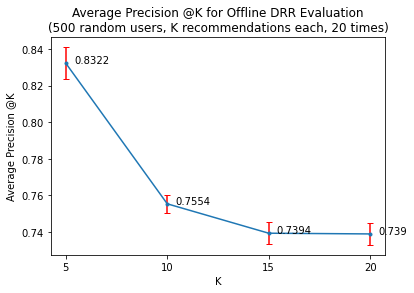

In [22]:
# Evaluation @K Graphing

def createEvalPlot(title, ylabel, xlabel, filename, x, y, e, e_x_off, e_y_off):
    plt.figure()
    plt.errorbar(x, y, yerr=e, fmt='.-', ecolor="red", capsize=3)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(x)
    for i, j in zip(x, y):
        plt.annotate(str(round(j, 4)), xy=(i+e_x_off, j+e_y_off))
    plt.savefig(filename)

# Combine data
pmf_offline_eval_data = [pmf_fives, pmf_tens, pmf_fifteens, pmf_twenties]
offline_eval_data = [drr_fives, drr_tens, drr_fifteens, drr_twenties]

# Calculate means and stds for graphing
pmf_offline_means, pmf_offline_stds = [], []
offline_means, offline_stds = [], []
    
for d in pmf_offline_eval_data:
    pmf_offline_means.append(np.mean(d))
    pmf_offline_stds.append(np.std(d))

for d in offline_eval_data:
    offline_means.append(np.mean(d))
    offline_stds.append(np.std(d))

print(pmf_offline_means)
print(pmf_offline_stds)
print(offline_means)
print(offline_stds)


# Create and save eval plots
createEvalPlot("Average Precision @K for Offline PMF Evaluation\n(500 random users, K recommendations each, 20 times)",
                   "Average Precision @K",
                   "K",
                   output_path + "pmf_offline_eval.png",
                   T_precisions,
                   pmf_offline_means,
                   pmf_offline_stds,
                   0.4,
                   0)

createEvalPlot("Average Precision @K for Offline DRR Evaluation\n(500 random users, K recommendations each, 20 times)",
                   "Average Precision @K",
                   "K",
                   output_path + "offline_eval.png",
                   T_precisions,
                   offline_means,
                   offline_stds,
                   0.4,
                   0)